# Assignment Two:  Sentiment Classification

For this exercise you will be using the "SemEval 2017 task 4" corpus provided on the module website, available through the following link: https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs918/semeval-tweets.tar.bz2 You will focus particularly on Subtask A, i.e. classifying the overall sentiment of a tweet as positive, negative or neutral.

You are requested to produce a Jupyter notebook for the coursework submission. The input to your program is the SemEval data downloaded. Note that TAs need to run your program on their own machine by using the original SemEval data. As such, don’t submit a Python program that takes as input some preprocessed files.

#### Import necessary packages
You may import more packages here.

In [1]:
# Import necessary packages
import re
from os.path import join
import numpy as np
import tarfile
import os

In [2]:
os.chdir('/dcs/large/u2164966/Natural Language Processing')

In [2]:
# Define test sets
testsets = ['twitter-test1.txt', 'twitter-test2.txt', 'twitter-test3.txt']

In [3]:
# Skeleton: Evaluation code for the test sets
def read_test(testset):
    '''
    readin the testset and return a dictionary
    :param testset: str, the file name of the testset to compare
    '''
    id_gts = {}
    with open(testset, 'r', encoding='utf8') as fh:
        for line in fh:
            fields = line.split('\t')
            tweetid = fields[0]
            gt = fields[1]

            id_gts[tweetid] = gt

    return id_gts


def confusion(id_preds, testset, classifier):
    '''
    print the confusion matrix of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    gts = []
    for m, c1 in id_gts.items():
        if c1 not in gts:
            gts.append(c1)

    gts = ['positive', 'negative', 'neutral']

    conf = {}
    for c1 in gts:
        conf[c1] = {}
        for c2 in gts:
            conf[c1][c2] = 0

    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'
        conf[pred][gt] += 1

    print(''.ljust(12) + '  '.join(gts))

    for c1 in gts:
        print(c1.ljust(12), end='')
        for c2 in gts:
            if sum(conf[c1].values()) > 0:
                print('%.3f     ' % (conf[c1][c2] / float(sum(conf[c1].values()))), end='')
            else:
                print('0.000     ', end='')
        print('')

    print('')


def evaluate(id_preds, testset, classifier):
    '''
    print the macro-F1 score of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    acc_by_class = {}
    for gt in ['positive', 'negative', 'neutral']:
        acc_by_class[gt] = {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}

    catf1s = {}

    ok = 0
    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'

        if gt == pred:
            ok += 1
            acc_by_class[gt]['tp'] += 1
        else:
            acc_by_class[gt]['fn'] += 1
            acc_by_class[pred]['fp'] += 1

    catcount = 0
    itemcount = 0
    macro = {'p': 0, 'r': 0, 'f1': 0}
    micro = {'p': 0, 'r': 0, 'f1': 0}
    semevalmacro = {'p': 0, 'r': 0, 'f1': 0}

    microtp = 0
    microfp = 0
    microtn = 0
    microfn = 0
    for cat, acc in acc_by_class.items():
        catcount += 1

        microtp += acc['tp']
        microfp += acc['fp']
        microtn += acc['tn']
        microfn += acc['fn']

        p = 0
        if (acc['tp'] + acc['fp']) > 0:
            p = float(acc['tp']) / (acc['tp'] + acc['fp'])

        r = 0
        if (acc['tp'] + acc['fn']) > 0:
            r = float(acc['tp']) / (acc['tp'] + acc['fn'])

        f1 = 0
        if (p + r) > 0:
            f1 = 2 * p * r / (p + r)

        catf1s[cat] = f1

        n = acc['tp'] + acc['fn']

        macro['p'] += p
        macro['r'] += r
        macro['f1'] += f1

        if cat in ['positive', 'negative']:
            semevalmacro['p'] += p
            semevalmacro['r'] += r
            semevalmacro['f1'] += f1

        itemcount += n

    micro['p'] = float(microtp) / float(microtp + microfp)
    micro['r'] = float(microtp) / float(microtp + microfn)
    micro['f1'] = 2 * float(micro['p']) * micro['r'] / float(micro['p'] + micro['r'])

    semevalmacrof1 = semevalmacro['f1'] / 2

    print(testset + ' (' + classifier + '): %.3f' % semevalmacrof1)

#### Load training set, dev set and testing set
Here, you need to load the training set, the development set and the test set. For better classification results, you may need to preprocess tweets before sending them to the classifiers.

In [2]:
# First, extract the compressed archive
import tarfile
import os
import shutil

# Path to your compressed file
compressed_file = 'semeval-tweets.tar.bz2'
extraction_dir = 'semeval-tweets'

# Extract the archive
try:
    print(f"Extracting {compressed_file}...")
    with tarfile.open(compressed_file, 'r:bz2') as tar:
        tar.extractall(path=extraction_dir)
    print("Extraction completed successfully!")
except Exception as e:
    print(f"Error extracting file: {e}")

Extracting semeval-tweets.tar.bz2...


/usr/lib64/python3.11/tarfile.py:2283: RuntimeWarning: The default behavior of tarfile extraction has been changed to disallow common exploits (including CVE-2007-4559). By default, absolute/parent paths are disallowed and some mode bits are cleared. See https://access.redhat.com/articles/7004769 for more details.
  warnings.warn(


Extraction completed successfully!


In [3]:
# Helper function to count sentiment classes
def sentiment_counts(sentiments):
    counts = {'positive': 0, 'negative': 0, 'neutral': 0}
    for sentiment in sentiments:
        if sentiment in counts:
            counts[sentiment] += 1
    return counts

# Load training set, dev set and testing set
data = {}
tweetids = {}
tweetgts = {}
tweets = {}

# Array of testsets
testsets = ['twitter-test1.txt', 'twitter-test2.txt', 'twitter-test3.txt']

# Define base directory where files are located
base_dir = os.path.join('semeval-tweets', 'semeval-tweets')

# Add dev set to the list of datasets to load
datasets = ['twitter-training-data.txt', 'twitter-dev-data.txt'] + testsets


for dataset in datasets:
    data[dataset] = []
    tweets[dataset] = []
    tweetids[dataset] = []
    tweetgts[dataset] = []
    
    file_path = os.path.join(base_dir, dataset)
    
    # Read the dataset
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                # Split by tab character
                fields = line.strip().split('\t')
                
                # Check if line has enough fields
                if len(fields) >= 3:
                    tweet_id = fields[0]          # First column: tweet ID
                    sentiment = fields[1]         # Second column: sentiment label
                    tweet_text = fields[2]        # Third column: tweet text
                    
                    # Store the data
                    data[dataset].append((tweet_id, sentiment, tweet_text))
                    tweetids[dataset].append(tweet_id)
                    tweetgts[dataset].append(sentiment)
                    tweets[dataset].append(tweet_text)
        
        print(f"Loaded {len(tweets[dataset])} tweets from {dataset}")
        print(f"Sentiments distribution in {dataset}: {sentiment_counts(tweetgts[dataset])}")
    except Exception as e:
        print(f"Error loading {dataset}: {e}")



Loaded 45101 tweets from twitter-training-data.txt
Sentiments distribution in twitter-training-data.txt: {'positive': 15986, 'negative': 8326, 'neutral': 20789}
Loaded 2000 tweets from twitter-dev-data.txt
Sentiments distribution in twitter-dev-data.txt: {'positive': 703, 'negative': 378, 'neutral': 919}
Loaded 3531 tweets from twitter-test1.txt
Sentiments distribution in twitter-test1.txt: {'positive': 1470, 'negative': 557, 'neutral': 1504}
Loaded 1853 tweets from twitter-test2.txt
Sentiments distribution in twitter-test2.txt: {'positive': 982, 'negative': 202, 'neutral': 669}
Loaded 2379 tweets from twitter-test3.txt
Sentiments distribution in twitter-test3.txt: {'positive': 1033, 'negative': 363, 'neutral': 983}


### Build sentiment classifiers
You need to create your own classifiers (at least 3 classifiers). For each classifier, you can choose between the bag-of-word features and the word-embedding-based features. Each classifier has to be evaluated over 3 test sets. Make sure your classifier produce consistent performance across the test sets. Marking will be based on the performance over all 5 test sets (2 of them are not provided to you).

#### Testing Preprocessing Pipeline

In [39]:
pip install emoji

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 11.2 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [11]:
import re
import string
import unicodedata
import html
from typing import List, Dict, Optional, Union, Set, Tuple
import warnings
import emoji

# Suppress any warnings to keep the notebook clean
warnings.filterwarnings('ignore')

class TwitterPreprocessor:
    """
    A comprehensive text preprocessing pipeline for Twitter data, 
    optimized for sentiment analysis tasks.
    """
    
    def __init__(self, 
                 remove_urls: bool = True,
                 remove_mentions: bool = True,
                 replace_emojis: bool = True,
                 handle_negations: bool = True,
                 replace_elongations: bool = True,
                 handle_hashtags: bool = True,
                 remove_numbers: bool = True):
        """
        Initialize the preprocessor with configurable options.
        
        Args:
            remove_urls: Whether to replace URLs with <URL> tag
            remove_mentions: Whether to replace @mentions with <USER> tag
            replace_emojis: Whether to replace emojis with semantic tags
            handle_negations: Whether to mark words after negation terms
            replace_elongations: Whether to normalize elongated words
            handle_hashtags: Whether to process hashtags
            remove_numbers: Whether to replace numbers with <NUMBER> tag
        """
        self.remove_urls = remove_urls
        self.remove_mentions = remove_mentions
        self.replace_emojis = replace_emojis
        self.handle_negations = handle_negations
        self.replace_elongations = replace_elongations
        self.handle_hashtags = handle_hashtags
        self.remove_numbers = remove_numbers
        
        # Regex flags for multiline processing
        self.flags = re.MULTILINE | re.DOTALL
        
        # Stopwords and function words that shouldn't be negated
        self.non_negatable_words = self._get_non_negatable_words()
        
        # Compile all regex patterns for efficiency
        self._compile_regex_patterns()
    
    def _compile_regex_patterns(self):
        """Compile all regex patterns used in preprocessing for better performance."""
        # Entity patterns
        self.url_pattern = re.compile(r'https?://\S+|www\.\S+')
        self.email_pattern = re.compile(r'[\w.+-]+@[\w-]+\.(?:[\w-]\.?)+[\w-]')
        self.mention_pattern = re.compile(r'@\w+')
        self.hashtag_pattern = re.compile(r'#(\w+)')
        self.hashtag_split_pattern = re.compile(r'(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|_')
        self.number_pattern = re.compile(r'\b[-+]?[\d,]*\.?\d+\b')
        self.emoticon_pattern = self._get_emoticon_patterns()
        
        # Text feature patterns
        self.elongated_pattern = re.compile(r'\b(\w*?)(.)\2{2,}\b')
        self.repeated_punct_pattern = re.compile(r'([!?])\1{1,}')  # Only for ! and ?
        self.ellipsis_pattern = re.compile(r'\.{3,}')
        self.word_split_pattern = re.compile(r'[/\-_]')
        self.all_caps_pattern = re.compile(r'\b([A-Z]{2,})\b(?!>)')
        self.emphasis_pattern = re.compile(r'\*(\w+|\s+\w+\s+)\*')
        
        # Contraction and possessive patterns
        self.contraction_patterns = self._get_contraction_patterns()
        self.possessive_pattern = re.compile(r'(\w+)\'s\b', re.IGNORECASE)
        
        # Negation pattern - improved to match specific negation terms
        self.negation_pattern = re.compile(
            r'\b(?:not|no|never|n\'t|isn\'t|aren\'t|wasn\'t|weren\'t|haven\'t|'
            r'hasn\'t|hadn\'t|won\'t|wouldn\'t|don\'t|doesn\'t|didn\'t)\b'
            r'(?:\s+(?:so|very|too|that|just|a|the|an|very|really|much|\w+ly))?'  # Optional intensifiers
            r'\s+(\w+(?:\s+\w+)?)'  # Capture up to 2 words that might be negated
        )
        
        # Double negation pattern - to avoid applying negation twice
        self.double_negation_pattern = re.compile(
            r'\b(?:not|no|never|n\'t)\b\s+\w+\s+\b(?:not|no|never|n\'t)\b'
        )
        
        # Heart emoticon pattern - needs to be detected before number handling
        self.heart_pattern = re.compile(r'<3')
        
        # Control characters and spacing
        self.control_char_pattern = re.compile(r'[\n\t\r]')
        self.multi_space_pattern = re.compile(r'\s+')
        
        # Special protected tags pattern
        self.protected_tags_pattern = re.compile(
            r'<(?:URL|USER|EMAIL|NUMBER|HASHTAG|SMILE|LOL|SAD|NEUTRAL|HEART|'
            r'REPEAT|ELONG|ALLCAPS|ANGRY|LOVE|EMPHASIS|ELLIPSIS)>|</HASHTAG>'
        )
        
        # Emoji dictionaries for Unicode emoji handling
        self.emoji_mappings = self._get_emoji_mappings()
    
    def _get_emoticon_patterns(self) -> Dict[str, re.Pattern]:
        """Create patterns for detecting common emoticons."""
        eyes = r'[8:=;]'
        nose = r"['`\-^]?"
        
        return {
            'smile': re.compile(f'{eyes}{nose}[)Dd]+|[(Dd]+{nose}{eyes}'),
            'lol': re.compile(f'{eyes}{nose}[pP]+'),
            'sad': re.compile(f'{eyes}{nose}\\(+|\\)+{nose}{eyes}'),
            'neutral': re.compile(f'{eyes}{nose}[|\\\\/]'),
            'heart': re.compile(r'♥')  # Moved <3 to separate pattern
        }
        
    def _get_emoji_mappings(self) -> Dict[str, List[str]]:
        """Define mappings for Unicode emojis to sentiment categories."""
        return {
            'SMILE': [
                '😀', '😃', '😄', '😁', '😆', '😊', '🙂', '😉', '😌', '😍', 
                '🥰', '😘', '😗', '😙', '😚', '😋', '😛', '😝', '😜', '🤪',
                '🤗', '🤭', '🥲', '☺️', '👍', '💪', '🔥', '✨', '💯', '👊',
                '👏', '🙏', '🤝', '👌', '👑', '💐', '🌟', '⭐', '🌈', '🌞'
            ],
            'SAD': [
                '☹️', '😞', '😔', '😟', '😕', '🙁', '😣', '😖', '😫', '😩',
                '🥺', '😢', '😭', '😮‍💨', '😤', '🥱', '😴', '👎', '💔', '😿'
            ],
            'ANGRY': [
                '😠', '😡', '🤬', '👿', '😤', '😾', '💢', '🗯️', '⚡', '☠️'
            ],
            'LOL': [
                '😂', '🤣', '🤭', '🤪', '🤡'
            ],
            'NEUTRAL': [
                '😐', '😑', '😶', '🤐', '😶‍🌫️', '😏', '😒', '🤷', '🤷‍♂️', 
                '🤷‍♀️', '👀', '🧐', '🤔'
            ],
            'HEART': [
                '❤️', '🧡', '💛', '💚', '💙', '💜', '🖤', '🤍', '🤎', '❣️',
                '💕', '💞', '💓', '💗', '💖', '💘', '💝', '💟', '💌', '♥️'
            ],
            'LOVE': [
                '🥰', '😍', '😘', '😗', '😙', '😚', '💑', '👩‍❤️‍👨', '👨‍❤️‍👨', '👩‍❤️‍👩',
                '💏', '👩‍❤️‍💋‍👨', '👨‍❤️‍💋‍👨', '👩‍❤️‍💋‍👩'
            ],
            'PARTY': [
                '🎉', '🎊', '🎂', '🎈', '🎁', '🎆', '🎇', '🎀', '🍾', '🥂'
            ],
            'FOOD': [
                '🍕', '🍔', '🍟', '🌭', '🍿', '🧂', '🥓', '🍖', '🍗', '🥩',
                '🍤', '🍳', '🍲', '🥣', '🥗', '🍜', '🍝', '🍱', '🍚', '🍛',
                '🍠', '🍢', '🍣', '🍤', '🍥', '🥮', '🍡', '🥟', '🥠', '🥡',
                '🍦', '🍧', '🍨', '🍩', '🍪', '🎂', '🍰', '🧁', '🥧', '🍫',
                '🍬', '🍭', '🍮', '🍯', '🍼', '🥛', '☕', '🍵', '🍶', '🍾',
                '🍷', '🍸', '🍹', '🍺', '🍻', '🥂', '🥃', '🧃', '🧉', '🧊'
            ],
            'SARCASM': [
                '🙄', '😒', '😏', '🤦', '🤦‍♂️', '🤦‍♀️', '🤨', '🧐'
            ]
        }
    
    def _get_contraction_patterns(self) -> Dict[str, str]:
        """Define mappings for expanding English contractions."""
        return {
            r"\bwon\'t\b": "will not",
            r"\bcan\'t\b": "cannot",
            r"\bcan't\b": "cannot",
            r"\bn\'t\b": " not",
            r"\bn't\b": " not",
            r"\b\'re\b": " are",
            r"\b're\b": " are",
            r"\b\'ve\b": " have",
            r"\b've\b": " have",
            r"\b\'ll\b": " will",
            r"\b'll\b": " will",
            r"\b\'d\b": " would",
            r"\b'd\b": " would",
            r"\b\'m\b": " am",
            r"\b'm\b": " am"
        }
    
    def decode_html_entities(self, text: str) -> str:
        """Decode HTML entities like &amp; to &."""
        return html.unescape(text)
        
    def normalize_unicode(self, text: str) -> str:
        """
        Normalize Unicode characters and remove control characters.
        
        Args:
            text: Input text
            
        Returns:
            Normalized text with consistent Unicode representation
        """
        # Normalize to NFKD form and remove accents
        text = unicodedata.normalize('NFKD', text)
        text = ''.join([c for c in text if not unicodedata.combining(c)])
        
        # Remove control characters
        text = self.control_char_pattern.sub(' ', text)
        
        return text
    
    def replace_urls(self, text: str) -> str:
        """Replace URLs with <URL> tag."""
        if self.remove_urls:
            return self.url_pattern.sub('<URL>', text)
        return text
    
    def replace_emails(self, text: str) -> str:
        """Replace email addresses with <EMAIL> tag."""
        return self.email_pattern.sub('<EMAIL>', text)
    
    def replace_mentions(self, text: str) -> str:
        """Replace user mentions with <USER> tag."""
        if self.remove_mentions:
            return self.mention_pattern.sub('<USER>', text)
        return text
    
    def replace_heart_emoticon(self, text: str) -> str:
        """Replace heart emoticon with <HEART> tag before number processing."""
        return self.heart_pattern.sub('<HEART>', text)
    
    def replace_numbers(self, text: str) -> str:
        """Replace numeric values with <NUMBER> tag."""
        if self.remove_numbers:
            return self.number_pattern.sub('<NUMBER>', text)
        return text
    
    def process_hashtags(self, text: str) -> str:
        """
        Process hashtags by splitting them into component words and adding <HASHTAG> tags.
        For example: #DataScience -> <HASHTAG> data science </HASHTAG>
        Handles both camelCase and underscores.
        """
        if not self.handle_hashtags:
            return text
            
        def split_hashtag(match):
            tag = match.group(1)
            # Convert camelCase or PascalCase or snake_case to space-separated words
            words = self.hashtag_split_pattern.sub(' ', tag)
            # Add spaces for all-caps hashtags (e.g., #NASA -> N A S A)
            if tag.isupper() and len(tag) > 1:
                words = ' '.join(list(words))
            return f'<HASHTAG> {words.lower()} </HASHTAG>'
            
        return self.hashtag_pattern.sub(split_hashtag, text)
    
    def replace_emoticons(self, text: str) -> str:
        """Replace text-based emoticons with semantic tags."""
        if not self.replace_emojis:
            return text
            
        for emotion, pattern in self.emoticon_pattern.items():
            text = pattern.sub(f'<{emotion.upper()}>', text)
        
        return text
        
    def replace_unicode_emojis(self, text: str) -> str:
        """Replace Unicode emojis with semantic tags."""
        if not self.replace_emojis:
            return text
            
        # Extract emojis and their positions
        emoji_list = emoji.emoji_list(text)
        
        # Replace from end to beginning to avoid position shifts
        result = text
        for item in reversed(emoji_list):
            emoji_char = item['emoji']
            start, end = item['match_start'], item['match_end']
            
            # Find which category this emoji belongs to
            category = None
            for cat, emoji_chars in self.emoji_mappings.items():
                if emoji_char in emoji_chars:
                    category = cat
                    break
            
            # If found, replace with the category tag
            if category:
                result = result[:start] + f" <{category}> " + result[end:]
            
        return result
    
    def handle_emphasis(self, text: str) -> str:
        """Convert *emphasized* text to an <EMPHASIS> tag."""
        return self.emphasis_pattern.sub(r'<EMPHASIS>\1</EMPHASIS>', text)
    
    def handle_ellipsis(self, text: str) -> str:
        """Replace ellipsis with <ELLIPSIS> tag to distinguish from repeated punctuation."""
        return self.ellipsis_pattern.sub(' <ELLIPSIS> ', text)
    
    def expand_contractions(self, text: str) -> str:
        """Expand common English contractions."""
        for pattern, replacement in self.contraction_patterns.items():
            text = re.sub(pattern, replacement, text)
        
        return text
    
    def handle_possessives(self, text: str) -> str:
        """
        Preserve possessive forms instead of expanding them as contractions.
        For example: "competitor's" should remain as a possessive, not "competitor is"
        """
        return self.possessive_pattern.sub(r'\1s', text)
    
    def expand_contractions(self, text: str) -> str:
        """Expand common English contractions."""
        for pattern, replacement in self.contraction_patterns.items():
            text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
        
        return text
    
    def handle_text_features(self, text: str) -> str:
        """Process text features like all-caps and elongated words."""
        # Mark all-caps words and convert to lowercase
        text = self.all_caps_pattern.sub(lambda m: f'{m.group(1).lower()}<ALLCAPS>', text)
        
        # Mark and normalize elongated words
        if self.replace_elongations:
            text = self.elongated_pattern.sub(lambda m: f'{m.group(1)}{m.group(2)} <ELONG>', text)
        
        # Mark repeated punctuation (only for ! and ?)
        text = self.repeated_punct_pattern.sub(lambda m: f'{m.group(1)} <REPEAT>', text)
        
        return text
    
    def mark_negations(self, text: str) -> str:
        """
        Mark words following negation terms with NEG_ prefix, with improved scope detection.
        Only negates sentiment-carrying words, not function words.
        """
        if not self.handle_negations:
            return text
        
        # First check if there's a double negation, which would be a positive
        if self.double_negation_pattern.search(text):
            # Don't mark negations in double negative constructions
            return text
            
        def negate(match):
            negation = match.group(0)
            following_words = match.group(1) if match.group(1) else ""
            
            # Split the following words
            words = following_words.split()
            
            # Only negate sentiment-relevant terms and limit the scope
            negated_words = []
            for word in words:
                # Skip negation for stopwords, function words, protected tags
                word_lower = word.lower()
                if (self.protected_tags_pattern.search(word) or 
                    word_lower in self.non_negatable_words or
                    word in string.punctuation):
                    negated_words.append(word)
                else:
                    # Only negate content words that might carry sentiment
                    negated_words.append(f'NEG_{word}')
            
            # Join the negated words back together
            negated_text = ' '.join(negated_words)
            
            # Return the original negation term followed by the negated words
            return negation.replace(following_words, negated_text)
            
        return self.negation_pattern.sub(negate, text)
    
    def normalize_spacing(self, text: str) -> str:
        """Normalize spacing in text."""
        # Replace multiple spaces with a single space
        text = self.multi_space_pattern.sub(' ', text)
        # Strip leading and trailing spaces
        return text.strip()
    
    def preprocess(self, text: str) -> str:
        """
        Apply the complete preprocessing pipeline to input text.
        
        Args:
            text: Raw input text
            
        Returns:
            Preprocessed text ready for sentiment analysis
        """
        if not text or not isinstance(text, str):
            return ""
        
        # Step 1: Decode HTML entities
        text = self.decode_html_entities(text)
            
        # Step 2: Basic normalization
        text = self.normalize_unicode(text)
        
        # Step 3: Handle <3 heart emoticon before number processing
        text = self.replace_heart_emoticon(text)
        
        # Step 4: Replace Unicode emojis - must be done early 
        # before they could be affected by other processing
        text = self.replace_unicode_emojis(text)
        
        # Step 5: Replace entities
        text = self.replace_urls(text)
        text = self.replace_emails(text)
        text = self.replace_mentions(text)
        text = self.replace_numbers(text)
        
        # Step 6: Process hashtags
        text = self.process_hashtags(text)
        
        # Step 7: Replace text-based emoticons
        text = self.replace_emoticons(text)
        
        # Step 8: Handle special text features
        text = self.handle_emphasis(text)
        text = self.handle_ellipsis(text)
        
        # Step 9: Handle possessives (before expanding contractions)
        text = self.handle_possessives(text)
        
        # Step 10: Expand contractions
        text = self.expand_contractions(text)
        
        # Step 11: Handle text features
        text = self.handle_text_features(text)
        
        # Step 12: Mark negations (important for sentiment)
        text = self.mark_negations(text)
        
        # Step 13: Final cleanup
        text = self.normalize_spacing(text)
        
        # Step 14: Convert to lowercase
        text = text.lower()
        
        return text
    
    def preprocess_batch(self, texts: List[str]) -> List[str]:
        """
        Preprocess a batch of texts.
        
        Args:
            texts: List of raw input texts
            
        Returns:
            List of preprocessed texts
        """
        return [self.preprocess(text) for text in texts]

    def _get_non_negatable_words(self) -> Set[str]:
        """Return a set of words that shouldn't be negated."""
        return {
            # Articles
            'a', 'an', 'the',
            # Prepositions
            'in', 'on', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 
            'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 
            'from', 'up', 'down', 'of', 'off',
            # Conjunctions
            'and', 'but', 'or', 'nor', 'so', 'yet', 'because', 'although', 'since',
            # Pronouns
            'i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them',
            'my', 'your', 'his', 'its', 'our', 'their', 'mine', 'yours', 'hers', 'ours', 'theirs',
            'this', 'that', 'these', 'those', 'who', 'whom', 'whose', 'which', 'what',
            # Other function words
            'is', 'am', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
            'do', 'does', 'did', 'will', 'would', 'shall', 'should', 'can', 'could', 'may',
            'might', 'must', 'ought', 'there', 'here', 'now', 'then', 'always', 'never'
        }

# Example function for tokenization after preprocessing
def tokenize(text: str) -> List[str]:
    """
    Tokenize preprocessed text into words.
    
    Args:
        text: Preprocessed text
        
    Returns:
        List of tokens
    """
    # Simple whitespace tokenization for preprocessed text
    return text.split()


# Function to show example preprocessing
def show_preprocessing_example(preprocessor: TwitterPreprocessor, example_texts: List[str]):
    """
    Demonstrate preprocessing on example texts.
    
    Args:
        preprocessor: Initialized TwitterPreprocessor
        example_texts: List of example raw texts
    """
    for i, text in enumerate(example_texts):
        processed = preprocessor.preprocess(text)
        print(f"Example {i+1}:")
        print(f"Original: {text}")
        print(f"Processed: {processed}")
        print(f"Tokens: {tokenize(processed)}")
        print("-" * 80)

In [4]:
# Create example tweets
example_tweets = [
    # Basic positive with multiple features
    "I absolutely LOVE this new phone!!! The battery life is incredible :D #technology #happy",
    
    # Negative with mention and emoji
    "Just upgraded to the latest iOS 14.5 @Apple and it's not working properly... 😠 #disappointed",
    
    # Neutral with URL
    "This movie wasn't as good as everyone said it would be. http://example.com/movie",
    
    # Mixed sentiment with repeated characters and heart emoticon
    "@JohnDoe can't believe you didn't like the concert! It was sooooo amazing!! <3",
    
    # Negative with pricing and emoticon
    "The price increased from $49.99 to $59.99 which isn't fair to loyal customers :(",
    
    # Mixed sentiment with hashtag
    "This restaurant has 5-star service but the food is only so-so. #foodie",
    
    # Retweet with nested mentions
    "RT @CelebChef: @FoodNetwork Your recipe for lasagna is absolutely to die for! Best I've ever had.",
    
    # Multiple emojis with contrasting sentiment
    "Got my exam results today 😭😭😭 But I passed! 🎉🎉🎉",
    
    # Sarcasm (hard to detect)
    "Oh great, another Monday morning meeting. Just what I needed to start my week.",
    
    # Non-English content mixed with English
    "The paella was muy delicioso! Best Spanish restaurant in town. #yummy",
    
    # HTML entities
    "I &amp; my friend enjoyed the movie. It was &quot;fantastic&quot;!",
    
    # Unicode characters
    "I'm in café drinking a latté with my fiancé – it's très magnifique!",
    
    # All caps for emphasis
    "CANNOT BELIEVE HOW AMAZING THIS CONCERT IS!!! MIND = BLOWN",
    
    # Hashtag with CamelCase and sentiment
    "Just finished my workout. #FeelingSoGood #FitLife",
    
    # Numbers as text
    "My 2nd time at this restaurant. The 1st was better tbh.",
    
    # Abbreviations and slang
    "OMG this new phone is lit AF! IMO it's the best one yet. ROFL at their competitors.",
    
    # Multiple URLs
    "Check out these reviews https://example.com/rev1 and https://example.com/rev2 before buying",
    
    # Mixed quotes
    "My friend said \"this was great\" but my sister said 'it was terrible'",
    
    # Conditional sentiment
    "If you like action movies, you'll love this. If not, you'll hate it.",
    
    # Negation with complex structure
    "I don't think it's not worth the money, but I wouldn't say it's amazing either.",
    
    # Date references
    "The Jan 15th release was better than the Mar 3rd one. #ProductUpdates",
    
    # Comparative sentiment
    "New version is better than old one but still worse than the competitor's.",
    
    # Asterisks for emphasis
    "This product is *absolutely* *incredible* and I *love* it!",
    
    # Sentiment transition in single tweet
    "Started watching the movie, hated the first hour, but the ending was incredible!",
    
    # Special Twitter formatting like polls
    "What do you think of the new update? POLL: Love it / Hate it / Neutral",
    
    # Emoji-only sentiment
    "After trying the new restaurant: 🍕👨‍🍳👌💯",
    
    # Multi-word hashtag with underscores
    "Just had the worst customer service experience. #never_shopping_here_again",
    
    # Ellipsis usage
    "The concert was... interesting... not what I expected...",
    
    # Unicode emojis and emoticons mixed
    "This made me smile :) 😊 and laugh 😂 but also cry 😢 :'(",
    
    # Numbers and symbols in hashtags
    "Just ran 5K in 30 mins! #personal_best #running101 #fitness4life",
    
    # Irony with emojis (difficult to detect)
    "Spending 3 hours on hold with customer service. So productive! 🙄",
    
    # Mentions in middle of sentences
    "I think @TechGuru's review was spot on! The phone camera is superb."
]

# Initialize the preprocessor
preprocessor = TwitterPreprocessor(
    remove_urls=True,
    remove_mentions=True,
    replace_emojis=True,
    handle_negations=True,
    replace_elongations=True,
    handle_hashtags=True,
    remove_numbers=True
)

# Process each example tweet
processed_tweets = []
for i, tweet in enumerate(example_tweets):
    processed = preprocessor.preprocess(tweet)
    processed_tweets.append(processed)
    
    print(f"Tweet {i+1}:")
    print(f"Original: {tweet}")
    print(f"Processed: {processed}")
    print("-" * 80)

Tweet 1:
Original: I absolutely LOVE this new phone!!! The battery life is incredible :D #technology #happy
Processed: i absolutely love<allcaps> this new phone! <repeat> the battery life is incredible <smile> <hashtag> technology </hashtag> <hashtag> happy </hashtag>
--------------------------------------------------------------------------------
Tweet 2:
Original: Just upgraded to the latest iOS 14.5 @Apple and it's not working properly... 😠 #disappointed
Processed: just upgraded to the latest ios <number> <user> and its not neg_working neg_properly <ellipsis> <angry> <hashtag> disappointed </hashtag>
--------------------------------------------------------------------------------
Tweet 3:
Original: This movie wasn't as good as everyone said it would be. http://example.com/movie
Processed: this movie wasn't neg_as neg_good as everyone said it would be. <url>
--------------------------------------------------------------------------------
Tweet 4:
Original: @JohnDoe can't believe you 

#### Naive Bayes

In [ ]:
pip install dill

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [8]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

def create_naive_bayes_classifier(features='bow'):
    """
    Create and return a Naive Bayes classifier for tweet sentiment analysis.
    
    Args:
        features: Feature type to use ('bow' for bag-of-words or 'tfidf' for TF-IDF)
    
    Returns:
        A scikit-learn Pipeline that combines preprocessing, feature extraction, and classification
    """
    # Initialize the preprocessor
    preprocessor = TwitterPreprocessor(
        remove_urls=True,
        remove_mentions=True,
        replace_emojis=True,
        handle_negations=True,
        replace_elongations=True,
        handle_hashtags=True,
        remove_numbers=True
    )
    
    # Select feature extraction method
    if features == 'bow':
        # Bag of Words vectorizer
        vectorizer = CountVectorizer(
            analyzer='word',
            tokenizer=lambda x: x.split(),  # Simple space tokenization
            preprocessor=lambda x: x,  # No additional preprocessing
            min_df=5,  # Ignore terms that appear in less than 5 documents
            max_df=0.7,  # Ignore terms that appear in more than 70% of documents
            ngram_range=(1, 2)  # Include unigrams and bigrams
        )
    elif features == 'tfidf':
        # TF-IDF vectorizer
        vectorizer = TfidfVectorizer(
            analyzer='word',
            tokenizer=lambda x: x.split(),
            preprocessor=lambda x: x,
            min_df=5,
            max_df=0.7,
            ngram_range=(1, 2),
            use_idf=True,
            sublinear_tf=True  # Apply sublinear tf scaling
        )
    else:
        raise ValueError(f"Unsupported feature type: {features}")
    
    # Create a pipeline
    nb_pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', MultinomialNB(alpha=1.0))  # Laplace smoothing
    ])
    
    return nb_pipeline, preprocessor

def train_naive_bayes(tweets, labels, features='bow'):
    """
    Train a Naive Bayes classifier on tweet data.
    
    Args:
        tweets: List of raw tweet texts
        labels: List of sentiment labels corresponding to tweets
        features: Feature type to use ('bow' or 'tfidf')
    
    Returns:
        Trained classifier pipeline and preprocessor
    """
    # Create classifier pipeline and preprocessor
    classifier_pipeline, preprocessor = create_naive_bayes_classifier(features)
    
    # Preprocess tweets
    preprocessed_tweets = preprocessor.preprocess_batch(tweets)
    
    # Train the classifier
    classifier_pipeline.fit(preprocessed_tweets, labels)
    
    return classifier_pipeline, preprocessor

def predict_sentiments(classifier_pipeline, preprocessor, tweets):
    """
    Predict sentiments for a list of tweets.
    
    Args:
        classifier_pipeline: Trained classifier pipeline
        preprocessor: Initialized TwitterPreprocessor
        tweets: List of raw tweet texts
    
    Returns:
        List of predicted sentiment labels
    """
    # Preprocess tweets
    preprocessed_tweets = preprocessor.preprocess_batch(tweets)
    
    # Make predictions
    predictions = classifier_pipeline.predict(preprocessed_tweets)
    
    return predictions

In [9]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def evaluate_classifier(classifier_pipeline, preprocessor, test_tweets, test_labels, average='macro'):
    """
    Evaluate the classifier using various metrics including F1 score.
    
    Args:
        classifier_pipeline: Trained classifier pipeline
        preprocessor: Initialized TwitterPreprocessor
        test_tweets: List of test tweet texts
        test_labels: True labels for test tweets
        average: Averaging method for F1 score ('macro', 'micro', 'weighted', or None)
                 For multi-class problems, 'macro' treats all classes equally
    
    Returns:
        Dictionary containing accuracy, precision, recall, and F1 score
    """
    # Get predictions
    predictions = predict_sentiments(classifier_pipeline, preprocessor, test_tweets)
    
    # Calculate metrics
    accuracy = accuracy_score(test_labels, predictions)
    precision = precision_score(test_labels, predictions, average=average, zero_division=0)
    recall = recall_score(test_labels, predictions, average=average, zero_division=0)
    f1 = f1_score(test_labels, predictions, average=average, zero_division=0)
    
    # Return all metrics as a dictionary
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
    
    return metrics

In [10]:
# First train the model on training data
train_tweets = tweets['twitter-training-data.txt']
train_labels = tweetgts['twitter-training-data.txt']

print("Training Naive Bayes classifier with BOW features...")
classifier, preprocessor = train_naive_bayes(train_tweets, train_labels, features='bow')

# Evaluate on development set
dev_tweets = tweets['twitter-dev-data.txt']
dev_labels = tweetgts['twitter-dev-data.txt']

dev_metrics = evaluate_classifier(classifier, preprocessor, dev_tweets, dev_labels)

print('\n== Development Set Metrics ==')
print(f"Accuracy: {dev_metrics['accuracy']:.4f}")
print(f"Precision: {dev_metrics['precision']:.4f}")
print(f"Recall: {dev_metrics['recall']:.4f}")
print(f"F1 Score: {dev_metrics['f1_score']:.4f}")  # macro F1 score

# List of test datasets
test_datasets = ['twitter-test1.txt', 'twitter-test2.txt', 'twitter-test3.txt']

# Evaluate on each test set
for test_set in test_datasets:
    print(f"\n== Test Set: {test_set} ==")
    
    # Skip if dataset doesn't exist
    if test_set not in tweets or test_set not in tweetgts:
        print(f"Dataset {test_set} not found, skipping.")
        continue
    
    test_tweets = tweets[test_set]
    test_labels = tweetgts[test_set]
    
    # Evaluate model
    test_metrics = evaluate_classifier(classifier, preprocessor, test_tweets, test_labels)
    
    # Print results
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")
    print(f"F1 Score: {test_metrics['f1_score']:.4f}")

# Optionally, summarize all metrics in a table
print("\n== Summary of Results ==")
print(f"{'Dataset':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
print("-" * 60)

# Development set
print(f"{'Dev Set':<20} {dev_metrics['accuracy']:<10.4f} {dev_metrics['precision']:<10.4f} {dev_metrics['recall']:<10.4f} {dev_metrics['f1_score']:<10.4f}")

# Test sets
for test_set in test_datasets:
    if test_set in tweets and test_set in tweetgts:
        test_tweets = tweets[test_set]
        test_labels = tweetgts[test_set]
        test_metrics = evaluate_classifier(classifier, preprocessor, test_tweets, test_labels)
        print(f"{test_set:<20} {test_metrics['accuracy']:<10.4f} {test_metrics['precision']:<10.4f} {test_metrics['recall']:<10.4f} {test_metrics['f1_score']:<10.4f}")

# Save the classifier and preprocessor to a dill file
import dill

with open('naive_bayes_classifier.pkl', 'wb') as f:
    dill.dump((classifier, preprocessor), f)

print("Model saved as naive_bayes_classifier.pkl")

Training Naive Bayes classifier with BOW features...

== Development Set Metrics ==
Accuracy: 0.6240
Precision: 0.6095
Recall: 0.6314
F1 Score: 0.6161

== Test Set: twitter-test1.txt ==
Accuracy: 0.6174
Precision: 0.6034
Recall: 0.5780
F1 Score: 0.5874

== Test Set: twitter-test2.txt ==
Accuracy: 0.6611
Precision: 0.6429
Recall: 0.5794
F1 Score: 0.6010

== Test Set: twitter-test3.txt ==
Accuracy: 0.6116
Precision: 0.5737
Recall: 0.5685
F1 Score: 0.5699

== Summary of Results ==
Dataset              Accuracy   Precision  Recall     F1 Score  
------------------------------------------------------------
Dev Set              0.6240     0.6095     0.6314     0.6161    
twitter-test1.txt    0.6174     0.6034     0.5780     0.5874    
twitter-test2.txt    0.6611     0.6429     0.5794     0.6010    
twitter-test3.txt    0.6116     0.5737     0.5685     0.5699    
Model saved as naive_bayes_classifier.pkl


#### MaxENT

In [6]:
import os
import numpy as np
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

warnings.filterwarnings('ignore')

# -----------------------------------------------
# 1) Load GloVe Embeddings
# -----------------------------------------------
def load_glove_embeddings(glove_file_path, embedding_dim=100):
    """
    Load GloVe embeddings into a dictionary.
    
    Args:
        glove_file_path (str): Path to the GloVe file (e.g. 'glove.6B.100d.txt').
        embedding_dim (int): Dimensionality of the embeddings.
    
    Returns:
        dict: Mapping of words to their embedding vectors.
    """
    embeddings = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if len(vector) == embedding_dim:
                embeddings[word] = vector
    return embeddings

# -----------------------------------------------
# 2) Load Opinion Lexicon (English)
# -----------------------------------------------
def load_opinion_lexicon(positive_file, negative_file):
    """
    Load the Opinion Lexicon from the specified positive and negative word files.
    
    Args:
        positive_file (str): Path to the file containing positive words.
        negative_file (str): Path to the file containing negative words.
    
    Returns:
        (set, set): A tuple containing the set of positive words and the set of negative words.
    """
    positive_words = set()
    negative_words = set()
    
    with open(positive_file, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line and not line.startswith(';'):
                positive_words.add(line.lower())
                
    with open(negative_file, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line and not line.startswith(';'):
                negative_words.add(line.lower())
                
    return positive_words, negative_words

# Global lexicon sets (to be loaded in main)
GLOBAL_POSITIVE_WORDS = set()
GLOBAL_NEGATIVE_WORDS = set()

def get_sentiment_features(tweet):
    """
    Compute sentiment features using the Opinion Lexicon.
    
    Args:
        tweet (str): Tweet text.
    
    Returns:
        np.array: Array with [positive_count, negative_count, compound_score].
    """
    tokens = tweet.lower().split()
    pos_count = sum(1 for token in tokens if token in GLOBAL_POSITIVE_WORDS)
    neg_count = sum(1 for token in tokens if token in GLOBAL_NEGATIVE_WORDS)
    total = len(tokens) if tokens else 1
    # Compound score: normalized difference between positive and negative counts
    compound = (pos_count - neg_count) / total
    return np.array([pos_count, neg_count, compound])

def tweet_to_combined_features(tweet, glove_embeddings, embedding_dim=100):
    """
    Convert a tweet into a combined feature vector consisting of:
      - The average GloVe embedding (dense features)
      - Sentiment scores from the Opinion Lexicon (lexicon-based features)
    
    Args:
        tweet (str): Preprocessed tweet text.
        glove_embeddings (dict): Loaded GloVe embeddings.
        embedding_dim (int): Dimensionality of the GloVe embeddings.
    
    Returns:
        np.array: Combined feature vector.
    """
    # Compute average GloVe embedding
    tokens = tweet.split()  # Assuming text has already been preprocessed
    vectors = []
    for token in tokens:
        if token in glove_embeddings:
            vectors.append(glove_embeddings[token])
        else:
            vectors.append(np.zeros(embedding_dim))
    glove_feature = np.mean(vectors, axis=0) if vectors else np.zeros(embedding_dim)
    
    # Compute sentiment features from Opinion Lexicon
    sentiment_feature = get_sentiment_features(tweet)
    
    # Concatenate both feature sets
    combined_feature = np.concatenate([glove_feature, sentiment_feature])
    return combined_feature

def prepare_combined_features(tweets_list, glove_embeddings, embedding_dim=100):
    """
    Prepare a feature matrix by converting each tweet into its combined feature vector.
    
    Args:
        tweets_list (list): List of preprocessed tweet texts.
        glove_embeddings (dict): Loaded GloVe embeddings.
        embedding_dim (int): Dimensionality of the GloVe embeddings.
    
    Returns:
        np.array: 2D array where each row is a combined tweet vector.
    """
    features = np.array([tweet_to_combined_features(tweet, glove_embeddings, embedding_dim)
                         for tweet in tweets_list])
    return features

# -----------------------------------------------
# 3) Evaluation Functions
# -----------------------------------------------
def evaluate_classifier(classifier, preprocessor, tweets, labels):
    """
    Evaluate the classifier by preprocessing tweets, extracting features,
    predicting sentiments, and computing evaluation metrics.
    
    Args:
        classifier: Trained classifier.
        preprocessor: Preprocessor instance with a 'preprocess' method.
        tweets (list): List of raw tweet texts.
        labels (list): True sentiment labels.
    
    Returns:
        dict: Dictionary with 'accuracy', 'precision', 'recall', and 'f1_score'.
    """
    # Preprocess tweets using the provided preprocessor
    processed_tweets = [preprocessor.preprocess(tweet) for tweet in tweets]
    # Use the global glove embeddings and embedding_dim variables with combined features
    X = prepare_combined_features(processed_tweets, global_glove_embeddings, global_embedding_dim)
    predictions = classifier.predict(X)
    metrics = {
        'accuracy': accuracy_score(labels, predictions),
        'precision': precision_score(labels, predictions, average='macro'),
        'recall': recall_score(labels, predictions, average='macro'),
        'f1_score': f1_score(labels, predictions, average='macro')
    }
    return metrics

def predict_sentiments_maxent(classifier, preprocessor, tweets):
    """
    Predict sentiments for a list of tweets using the classifier.
    
    Args:
        classifier: Trained classifier.
        preprocessor: Preprocessor instance with a 'preprocess' method.
        tweets (list): List of raw tweet texts.
    
    Returns:
        np.array: Predicted sentiment labels.
    """
    processed_tweets = [preprocessor.preprocess(tweet) for tweet in tweets]
    X = prepare_combined_features(processed_tweets, global_glove_embeddings, global_embedding_dim)
    return classifier.predict(X)

# -----------------------------------------------
# 4) Maximum Entropy Classifier with Grid Search
# -----------------------------------------------
def run_grid_search(X_train, y_train):
    """
    Run grid search on a logistic regression (MaxEnt) classifier with multiple solvers,
    penalties, and class_weight options. Returns the best logistic regression estimator.
    """
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import GridSearchCV

    # Define parameter grids for different solvers
    param_grid_lr = [
        {
            'solver': ['lbfgs'],
            'penalty': ['l2'],
            'C': [0.01, 0.1, 1, 10, 100],
            'class_weight': [None, 'balanced'],
            'multi_class': ['multinomial']
        },
        {
            'solver': ['liblinear'],
            'penalty': ['l1', 'l2'],
            'C': [0.01, 0.1, 1, 10, 100],
            'class_weight': [None, 'balanced'],
            'multi_class': ['ovr']  # liblinear supports only one-vs-rest
        },
    ]
    
    lr = LogisticRegression(max_iter=1000)
    grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=5,
                                  scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search_lr.fit(X_train, y_train)
    
    print("Best parameters for Logistic Regression found:", grid_search_lr.best_params_)
    print("Best cross-validation score: {:.2f}".format(grid_search_lr.best_score_))
    
    best_lr = grid_search_lr.best_estimator_
    return best_lr

# -----------------------------------------------
# 5) Main Function
# -----------------------------------------------
def main():
    # Path to the GloVe file and embedding dimensions
    glove_file_path = 'glove.6B.100d.txt'  # Update this path as needed
    embedding_dim = 100

    # Load GloVe embeddings and assign to global variables
    print("Loading GloVe embeddings...")
    glove_embeddings = load_glove_embeddings(glove_file_path, embedding_dim)
    global global_glove_embeddings, global_embedding_dim
    global_glove_embeddings = glove_embeddings
    global_embedding_dim = embedding_dim

    # Load Opinion Lexicon from provided files
    positive_lexicon_file = 'positive-words.txt'
    negative_lexicon_file = 'negative-words.txt'
    print("Loading Opinion Lexicon...")
    global GLOBAL_POSITIVE_WORDS, GLOBAL_NEGATIVE_WORDS
    GLOBAL_POSITIVE_WORDS, GLOBAL_NEGATIVE_WORDS = load_opinion_lexicon(positive_lexicon_file, negative_lexicon_file)

    # ---------------------------------------------------------------
    # Define data from your tweet-processing pipeline
    # (Assumes tweets and tweetgts dictionaries are defined elsewhere)
    train_tweets = tweets['twitter-training-data.txt']
    train_labels = tweetgts['twitter-training-data.txt']

    # Development set
    dev_tweets = tweets['twitter-dev-data.txt']
    dev_labels = tweetgts['twitter-dev-data.txt']

    # Test sets
    test_datasets = ['twitter-test1.txt', 'twitter-test2.txt', 'twitter-test3.txt']
    # ---------------------------------------------------------------

    # Instantiate your preprocessor (assumed to be defined elsewhere)
    preprocessor = TwitterPreprocessor(
        remove_urls=True,
        remove_mentions=True,
        replace_emojis=True,
        handle_negations=True,
        replace_elongations=True,
        handle_hashtags=True,
        remove_numbers=True
    )
    
    # Prepare feature matrices for training data
    print("Extracting features from training data...")
    # Note: It is assumed that the tweets in train_tweets are raw texts.
    processed_train = [preprocessor.preprocess(tweet) for tweet in train_tweets]
    X_train = prepare_combined_features(processed_train, glove_embeddings, embedding_dim)
    
    # Run grid search to find the best classifier
    print("Running grid search for hyperparameter tuning...")
    best_model = run_grid_search(X_train, train_labels)
    classifier = best_model  # For clarity in evaluation code

    # Define the solver used
    solver = "lbfgs"
    
    # ----------------------------
    # Evaluate on Dev Set
    # ----------------------------
    dev_metrics = evaluate_classifier(classifier, preprocessor, dev_tweets, dev_labels)
    dev_predictions = predict_sentiments_maxent(classifier, preprocessor, dev_tweets)
    dev_cm = confusion_matrix(dev_labels, dev_predictions)
    
    print(f"\n== Development Set Metrics (Solver: {solver}) ==")
    print(f"Accuracy: {dev_metrics['accuracy']:.4f}")
    print(f"Precision: {dev_metrics['precision']:.4f}")
    print(f"Recall: {dev_metrics['recall']:.4f}")
    print(f"F1 Score: {dev_metrics['f1_score']:.4f}")
    print("Confusion Matrix:")
    print(dev_cm)
    
    results = {}
    results[solver] = {
        'dev': {
            'metrics': dev_metrics,
            'confusion_matrix': dev_cm
        },
        'tests': {}
    }
    
    # ----------------------------
    # Evaluate on Test Sets
    # ----------------------------
    for test_set in test_datasets:
        print(f"\n== Test Set: {test_set} (Solver: {solver}) ==")
        if test_set not in tweets or test_set not in tweetgts:
            print(f"Dataset {test_set} not found, skipping.")
            continue
        
        test_tweets = tweets[test_set]
        test_labels = tweetgts[test_set]
        
        test_metrics = evaluate_classifier(classifier, preprocessor, test_tweets, test_labels)
        test_predictions = predict_sentiments_maxent(classifier, preprocessor, test_tweets)
        test_cm = confusion_matrix(test_labels, test_predictions)
        
        print(f"Accuracy: {test_metrics['accuracy']:.4f}")
        print(f"Precision: {test_metrics['precision']:.4f}")
        print(f"Recall: {test_metrics['recall']:.4f}")
        print(f"F1 Score: {test_metrics['f1_score']:.4f}")
        print("Confusion Matrix:")
        print(test_cm)
        
        results[solver]['tests'][test_set] = {
            'metrics': test_metrics,
            'confusion_matrix': test_cm
        }
    
    # ============================
    # Summary of Results
    # ============================
    print("\n=== Summary of Results ===")
    for solver_key, data in results.items():
        dev = data['dev']['metrics']
        print(f"\nSolver: {solver_key}")
        print("Dev Set:")
        print(f"  Accuracy : {dev['accuracy']:.4f}")
        print(f"  Precision: {dev['precision']:.4f}")
        print(f"  Recall   : {dev['recall']:.4f}")
        print(f"  F1 Score : {dev['f1_score']:.4f}")
        print("  Confusion Matrix:")
        print(data['dev']['confusion_matrix'])
        
        for test_set, test_data in data['tests'].items():
            test_metrics = test_data['metrics']
            print(f"\nTest Set: {test_set}")
            print(f"  Accuracy : {test_metrics['accuracy']:.4f}")
            print(f"  Precision: {test_metrics['precision']:.4f}")
            print(f"  Recall   : {test_metrics['recall']:.4f}")
            print(f"  F1 Score : {test_metrics['f1_score']:.4f}")
            print("  Confusion Matrix:")
            print(test_data['confusion_matrix'])

    # ----------------------------
    # Save the classifier and preprocessor to a pickle file using dill
    # ----------------------------
    with open('maxent_model.pkl', 'wb') as f:
        dill.dump((classifier, preprocessor), f)
    print("\nModel saved as maxent_model.pkl")
            
if __name__ == '__main__':
    main()


Loading GloVe embeddings...
Loading Opinion Lexicon...
Extracting features from training data...
Running grid search for hyperparameter tuning...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters for Logistic Regression found: {'C': 10, 'class_weight': None, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.60

== Development Set Metrics (Solver: lbfgs) ==
Accuracy: 0.6095
Precision: 0.6157
Recall: 0.5627
F1 Score: 0.5773
Confusion Matrix:
[[146 184  48]
 [ 65 671 183]
 [ 25 276 402]]

== Test Set: twitter-test1.txt (Solver: lbfgs) ==
Accuracy: 0.5990
Precision: 0.6430
Recall: 0.5227
F1 Score: 0.5355
Confusion Matrix:
[[ 132  333   92]
 [  26 1155  323]
 [  27  615  828]]

== Test Set: twitter-test2.txt (Solver: lbfgs) ==
Accuracy: 0.6050
Precision: 0.5873
Recall: 0.5019
F1 Score: 0.5038
Confusion Matrix:
[[ 33  98  71]
 [ 13 492 164]
 [ 16 370 596]]

== Test Set: twitter-test3.txt (Solver: lbfgs) ==
Accuracy: 0.596

#### Downloading Glove Embeddings

In [11]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2025-03-18 15:03:41--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-03-18 15:03:41--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-03-18 15:03:42--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [13]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [14]:
!ls

cs918_assignment_2.ipynb  glove.6B.300d.txt  semeval-tweets
glove.6B.100d.txt	  glove.6B.50d.txt   semeval-tweets.tar.bz2
glove.6B.200d.txt	  glove.6B.zip


#### LSTM

Document length statistics:
- Min length: 2
- Max length: 65
- Mean length: 20.97
- Median length: 21.00
- Standard deviation: 6.01
- 95th percentile: 30.00

Recommended maximum sequence length: 30


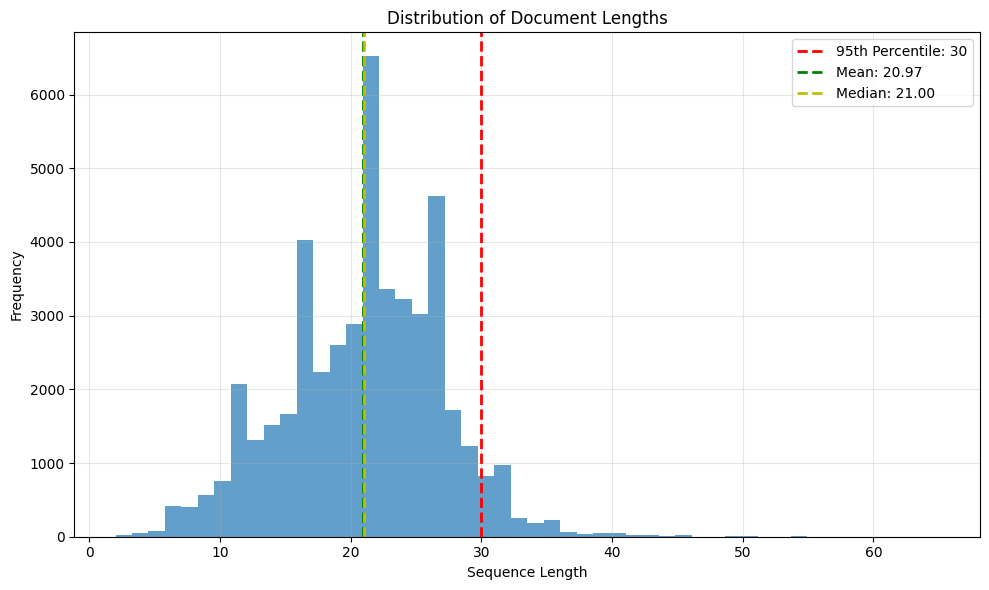

Setting max_sequence_length = 30


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer

preprocessor = TwitterPreprocessor(
    remove_urls=True,
    remove_mentions=True,
    replace_emojis=True,
    handle_negations=True,
    replace_elongations=True,
    handle_hashtags=True,
    remove_numbers=True
)

def analyze_document_lengths(texts, visualize=True, percentile=95):
    """
    Analyze the length of documents in a corpus and determine an appropriate
    maximum sequence length.
    
    Args:
        texts: List of text documents/tweets
        visualize: Whether to create a visualization of document lengths
        percentile: Which percentile to use for max_length recommendation
        
    Returns:
        dict: Dictionary containing various length statistics
    """
    # Tokenize the texts
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    
    # Convert texts to sequences
    sequences = tokenizer.texts_to_sequences(texts)
    
    # Calculate lengths of each sequence
    sequence_lengths = [len(seq) for seq in sequences]
    
    # Calculate statistics
    stats = {
        'max_length': max(sequence_lengths),
        'min_length': min(sequence_lengths),
        'mean_length': np.mean(sequence_lengths),
        'median_length': np.median(sequence_lengths),
        'std_length': np.std(sequence_lengths),
        f'{percentile}th_percentile': np.percentile(sequence_lengths, percentile)
    }
    
    # Print statistics
    print(f"Document length statistics:")
    print(f"- Min length: {stats['min_length']}")
    print(f"- Max length: {stats['max_length']}")
    print(f"- Mean length: {stats['mean_length']:.2f}")
    print(f"- Median length: {stats['median_length']:.2f}")
    print(f"- Standard deviation: {stats['std_length']:.2f}")
    print(f"- {percentile}th percentile: {stats[f'{percentile}th_percentile']:.2f}")
    
    recommended_length = int(stats[f'{percentile}th_percentile'])
    print(f"\nRecommended maximum sequence length: {recommended_length}")
    
    # Visualize the distribution of sequence lengths
    if visualize:
        plt.figure(figsize=(10, 6))
        plt.hist(sequence_lengths, bins=50, alpha=0.7)
        plt.axvline(recommended_length, color='r', linestyle='dashed', linewidth=2, 
                   label=f'{percentile}th Percentile: {recommended_length}')
        plt.axvline(stats['mean_length'], color='g', linestyle='dashed', linewidth=2,
                   label=f'Mean: {stats["mean_length"]:.2f}')
        plt.axvline(stats['median_length'], color='y', linestyle='dashed', linewidth=2,
                   label=f'Median: {stats["median_length"]:.2f}')
        plt.xlabel('Sequence Length')
        plt.ylabel('Frequency')
        plt.title('Distribution of Document Lengths')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    return stats, recommended_length

# Combine all your training, validation, and test sets to get a complete picture
all_texts = []
for dataset in ['twitter-training-data.txt', 'twitter-dev-data.txt']:
    if dataset in tweets:
        all_texts.extend(preprocessor.preprocess_batch(tweets[dataset]))

# Analyze document lengths
stats, recommended_max_length = analyze_document_lengths(all_texts, visualize=True, percentile=95)

# Use the recommended length to set max_sequence_length for your model
max_sequence_length = recommended_max_length
print(f"Setting max_sequence_length = {max_sequence_length}")


##### Basic LSTM

Despite this seq length of 128 seems to perform better

In [19]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# -------------------------------
# Data Preparation for Basic LSTM
# -------------------------------
# Load your raw tweet texts and labels from files or dataframes
# Note: This is a placeholder - you would need to define how to load tweets and labels
raw_train_texts = tweets['twitter-training-data.txt']
train_labels_str = tweetgts['twitter-training-data.txt']
raw_dev_texts = tweets['twitter-dev-data.txt']
dev_labels_str = tweetgts['twitter-dev-data.txt']

# Preprocess the tweets - this assumes a TwitterPreprocessor is defined elsewhere
preprocessor = TwitterPreprocessor(
    remove_urls=True,
    remove_mentions=True,
    replace_emojis=True,
    handle_negations=True,
    replace_elongations=True,
    handle_hashtags=True,
    remove_numbers=True
)

# Preprocess the tweets
train_texts = preprocessor.preprocess_batch(raw_train_texts)
dev_texts = preprocessor.preprocess_batch(raw_dev_texts)

# Encode sentiment labels to integers
label_encoder = LabelEncoder()
train_labels_int = label_encoder.fit_transform(train_labels_str)
dev_labels_int = label_encoder.transform(dev_labels_str)

# Tokenizer parameters - using 5,000 as per requirements
max_num_words = 5000
max_sequence_length = 128   # 128 to encapsulate eveything
embedding_dim = 100

tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(train_texts)
word_index = tokenizer.word_index

# Convert tweets to sequences and pad them
train_sequences = tokenizer.texts_to_sequences(train_texts)
train_data = pad_sequences(train_sequences, maxlen=max_sequence_length)
dev_sequences = tokenizer.texts_to_sequences(dev_texts)
dev_data = pad_sequences(dev_sequences, maxlen=max_sequence_length)

# -------------------------------
# Prepare the GloVe Embedding Matrix
# -------------------------------
glove_file_path = "glove.6B.100d.txt"  # Using the 100d GloVe embeddings
embedding_index = {}
with open(glove_file_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

num_words = min(max_num_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_num_words:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# -------------------------------
# Prepare Torch Tensors and DataLoaders
# -------------------------------
train_tensor = torch.tensor(train_data, dtype=torch.long)
train_labels_tensor = torch.tensor(train_labels_int, dtype=torch.long)
dev_tensor = torch.tensor(dev_data, dtype=torch.long)
dev_labels_tensor = torch.tensor(dev_labels_int, dtype=torch.long)

batch_size = 64
train_dataset = TensorDataset(train_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_dataset = TensorDataset(dev_tensor, dev_labels_tensor)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size)

# -------------------------------
# Define the Basic LSTM Model
# -------------------------------
class BasicLSTMClassifier(nn.Module):
    def __init__(self, num_words, embedding_dim, embedding_matrix, hidden_dim, num_classes):
        super(BasicLSTMClassifier, self).__init__()
        # Embedding layer with pretrained GloVe embeddings (frozen)
        self.embedding = nn.Embedding(num_words, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False  # Freeze the embedding layer
        
        # Single LSTM layer (not bidirectional)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )
        
        # Linear classifier layer
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        # x: (batch, seq_len)
        x = self.embedding(x)  # (batch, seq_len, embedding_dim)
        # Pass through LSTM
        lstm_out, (hidden, _) = self.lstm(x)  # hidden: (1, batch, hidden_dim)
        
        # Use the final hidden state for classification
        hidden = hidden.squeeze(0)  # (batch, hidden_dim)
        
        # Pass through linear layer for classification
        logits = self.fc(hidden)
        return logits

# -------------------------------
# Model Parameters and Instantiation
# -------------------------------
hidden_dim = 128
num_classes = 3  # Assuming 3 sentiment classes (negative, neutral, positive)

model = BasicLSTMClassifier(
    num_words=num_words,
    embedding_dim=embedding_dim,
    embedding_matrix=embedding_matrix,
    hidden_dim=hidden_dim,
    num_classes=num_classes
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# -------------------------------
# Training Setup
# -------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

# -------------------------------
# Training Loop
# -------------------------------
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    
    for batch_inputs, batch_labels in train_loader:
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * batch_inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()
    
    train_loss = epoch_loss / total
    train_accuracy = correct / total
    
    # Evaluate on the development set
    model.eval()
    dev_loss = 0.0
    dev_correct = 0
    dev_total = 0
    with torch.no_grad():
        for dev_inputs, dev_labels in dev_loader:
            dev_inputs = dev_inputs.to(device)
            dev_labels = dev_labels.to(device)
            outputs = model(dev_inputs)
            loss = criterion(outputs, dev_labels)
            dev_loss += loss.item() * dev_inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            dev_total += dev_labels.size(0)
            dev_correct += (predicted == dev_labels).sum().item()
    
    dev_loss = dev_loss / dev_total
    dev_accuracy = dev_correct / dev_total
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | Dev Loss: {dev_loss:.4f}, Dev Acc: {dev_accuracy:.4f}")

# -------------------------------
# Final Evaluation on Dev Set
# -------------------------------
model.eval()
all_preds = []
with torch.no_grad():
    for dev_inputs, _ in dev_loader:
        dev_inputs = dev_inputs.to(device)
        outputs = model(dev_inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())

print(f"Final Development set accuracy: {dev_accuracy:.4f}")

Epoch 1/10 - Train Loss: 0.8679, Train Acc: 0.5811 | Dev Loss: 0.8230, Dev Acc: 0.6150
Epoch 2/10 - Train Loss: 0.7933, Train Acc: 0.6305 | Dev Loss: 0.7818, Dev Acc: 0.6440
Epoch 3/10 - Train Loss: 0.7624, Train Acc: 0.6471 | Dev Loss: 0.7514, Dev Acc: 0.6580
Epoch 4/10 - Train Loss: 0.7402, Train Acc: 0.6573 | Dev Loss: 0.7446, Dev Acc: 0.6650
Epoch 5/10 - Train Loss: 0.7181, Train Acc: 0.6721 | Dev Loss: 0.7407, Dev Acc: 0.6660
Epoch 6/10 - Train Loss: 0.6953, Train Acc: 0.6854 | Dev Loss: 0.7417, Dev Acc: 0.6615
Epoch 7/10 - Train Loss: 0.6714, Train Acc: 0.6983 | Dev Loss: 0.7323, Dev Acc: 0.6700
Epoch 8/10 - Train Loss: 0.6435, Train Acc: 0.7128 | Dev Loss: 0.7337, Dev Acc: 0.6660
Epoch 9/10 - Train Loss: 0.6152, Train Acc: 0.7279 | Dev Loss: 0.7477, Dev Acc: 0.6540
Epoch 10/10 - Train Loss: 0.5806, Train Acc: 0.7443 | Dev Loss: 0.7701, Dev Acc: 0.6480
Final Development set accuracy: 0.6480


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import numpy as np
import dill  # For serializing objects that pickle might not handle

# Iterate through each test set (assumed to be defined in a list called testsets)
for test_set in testsets:
    print(f"\nEvaluating on test set: {test_set}")
    
    # Get the raw texts and sentiment labels
    test_texts = tweets[test_set]
    test_labels_str = tweetgts[test_set]
    
    # Preprocess the texts using the existing preprocessor
    processed_test_texts = preprocessor.preprocess_batch(test_texts)
    
    # Tokenize and pad sequences
    test_sequences = tokenizer.texts_to_sequences(processed_test_texts)
    test_data = pad_sequences(test_sequences, maxlen=max_sequence_length)
    
    # Convert to torch tensors
    test_tensor = torch.tensor(test_data, dtype=torch.long)
    
    # Encode sentiment labels to integers using the same label encoder
    test_labels_int = label_encoder.transform(test_labels_str)
    test_labels_tensor = torch.tensor(test_labels_int, dtype=torch.long)
    
    # Create a DataLoader for batching - note that we no longer include engineered features
    test_dataset = torch.utils.data.TensorDataset(test_tensor, test_labels_tensor)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    model.eval()
    all_preds = []
    all_true = []
    test_loss = 0.0
    total = 0
    correct = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass: only pass the tokenized inputs (no engineered features)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_true.extend(labels.cpu().numpy())
    
    test_loss /= total
    test_accuracy = correct / total
    
    # Compute metrics using scikit-learn
    metrics = {
        'accuracy': accuracy_score(all_true, all_preds),
        'precision': precision_score(all_true, all_preds, average='macro', zero_division=0),
        'recall': recall_score(all_true, all_preds, average='macro', zero_division=0),
        'f1_score': f1_score(all_true, all_preds, average='macro', zero_division=0)
    }
    
    cm = confusion_matrix(all_true, all_preds)
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print("Confusion Matrix:")
    print(cm)

# ----------------------------
# Save the basic LSTM model and associated components
# ----------------------------

# Save the basic LSTM model's state dictionary
torch.save(model.state_dict(), 'basic_lstm_model.pt')
print("\nBasic LSTM model saved as basic_lstm_model.pt")

# Save tokenizer, label encoder, and preprocessor using dill
with open('basic_tokenizer.pkl', 'wb') as f:
    dill.dump(tokenizer, f)
with open('basic_label_encoder.pkl', 'wb') as f:
    dill.dump(label_encoder, f)
with open('basic_preprocessor.pkl', 'wb') as f:
    dill.dump(preprocessor, f)
print("Tokenizer, label encoder, and preprocessor saved as tokenizer.pkl, label_encoder.pkl, and preprocessor.pkl respectively.")



Evaluating on test set: twitter-test1.txt
Test Loss: 0.7535
Test Accuracy: 0.6621
Precision: 0.6566
Recall: 0.6195
F1 Score: 0.6327
Confusion Matrix:
[[ 255  245   57]
 [  77 1066  361]
 [  72  381 1017]]

Evaluating on test set: twitter-test2.txt
Test Loss: 0.7091
Test Accuracy: 0.6859
Precision: 0.6651
Recall: 0.6317
F1 Score: 0.6423
Confusion Matrix:
[[ 95  74  33]
 [ 34 477 158]
 [ 24 259 699]]

Evaluating on test set: twitter-test3.txt
Test Loss: 0.8334
Test Accuracy: 0.6318
Precision: 0.6147
Recall: 0.5967
F1 Score: 0.6007
Confusion Matrix:
[[168 161  34]
 [ 90 708 185]
 [ 67 339 627]]

Basic LSTM model saved as basic_lstm_model.pt
Tokenizer, label encoder, and preprocessor saved as tokenizer.pkl, label_encoder.pkl, and preprocessor.pkl respectively.


##### Improved LSTM

In [ ]:
import os
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# -------------------------------
# Load Opinion Lexicon English Words
# -------------------------------
def load_opinion_lexicon(filepath):
    words = set()
    with open(filepath, 'r', encoding='latin-1') as f:
        for line in f:
            line = line.strip()
            # Ignore comments and blank lines
            if line and not line.startswith(';'):
                words.add(line.lower())
    return words

# Paths to the opinion lexicon files (adjust paths as needed)
positive_lexicon_path = "positive-words.txt"
negative_lexicon_path = "negative-words.txt"

positive_words = load_opinion_lexicon(positive_lexicon_path)
negative_words = load_opinion_lexicon(negative_lexicon_path)

# -------------------------------
# Additional Feature Engineering Functions
# -------------------------------
def extract_engineered_features(tweet):
    """
    Extracts engineered features from a tweet:
      - Lexicon counts: positive and negative word counts (2 features)
      - Ratio of positive to negative words (1 feature)
      - Sentiment score: (pos - neg) / (pos + neg) (1 feature)
      - Tweet length in words (1 feature)
      - Capitalization ratio (1 feature)
    Total = 6 features per tweet.
    """
    features = []
    
    # Tokenize and prepare for analysis
    tokens = tweet.split()
    text_length = len(tokens)
    uppercase_count = sum(1 for c in tweet if c.isupper())
    
    # Lexicon-based counts using Opinion Lexicon
    pos_count = sum(1 for t in tokens if t.lower() in positive_words)
    neg_count = sum(1 for t in tokens if t.lower() in negative_words)
    
    # Calculate ratio (handle division by zero)
    pos_neg_ratio = pos_count / max(1, neg_count)
    
    # Calculate sentiment score: (pos - neg) / (pos + neg)
    total_sentiment_words = pos_count + neg_count
    sentiment_score = 0 if total_sentiment_words == 0 else (pos_count - neg_count) / total_sentiment_words
    
    # Calculate capitalization ratio
    cap_ratio = 0 if len(tweet) == 0 else uppercase_count / len(tweet)
    
    # Combine all features
    features.extend([pos_count, neg_count, pos_neg_ratio, sentiment_score, text_length, cap_ratio])
    
    return features

# -------------------------------
# Data Preparation for LSTM (and engineered features)
# -------------------------------
# Load your raw tweet texts and labels from files or dataframes
raw_train_texts = tweets['twitter-training-data.txt']
train_labels_str = tweetgts['twitter-training-data.txt']
raw_dev_texts = tweets['twitter-dev-data.txt']
dev_labels_str = tweetgts['twitter-dev-data.txt']

# Instantiate your TwitterPreprocessor (assumed to be defined elsewhere)
preprocessor = TwitterPreprocessor(
    remove_urls=True,
    remove_mentions=True,
    replace_emojis=True,
    handle_negations=True,
    replace_elongations=True,
    handle_hashtags=True,
    remove_numbers=True
)

# Preprocess the tweets (for the LSTM branch)
train_texts = preprocessor.preprocess_batch(raw_train_texts)
dev_texts = preprocessor.preprocess_batch(raw_dev_texts)

# Compute engineered features
train_engineered = [extract_engineered_features(tweet) for tweet in train_texts]
dev_engineered = [extract_engineered_features(tweet) for tweet in dev_texts]

# Encode sentiment labels to integers
label_encoder = LabelEncoder()
train_labels_int = label_encoder.fit_transform(train_labels_str)
dev_labels_int = label_encoder.transform(dev_labels_str)

# Tokenizer parameters
max_num_words = 40000
max_sequence_length = 128   # Adjust depending on tweet lengths
embedding_dim = 100

tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(train_texts)
word_index = tokenizer.word_index

# Convert tweets to sequences and pad them
train_sequences = tokenizer.texts_to_sequences(train_texts)
train_data = pad_sequences(train_sequences, maxlen=max_sequence_length)
dev_sequences = tokenizer.texts_to_sequences(dev_texts)
dev_data = pad_sequences(dev_sequences, maxlen=max_sequence_length)

# -------------------------------
# Prepare the GloVe Embedding Matrix
# -------------------------------
glove_file_path = "glove.6B.100d.txt"
embedding_index = {}
with open(glove_file_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

num_words = min(max_num_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_num_words:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# -------------------------------
# Prepare Torch Tensors and DataLoaders
# -------------------------------
train_tensor = torch.tensor(train_data, dtype=torch.long)
train_labels_tensor = torch.tensor(train_labels_int, dtype=torch.long)
dev_tensor = torch.tensor(dev_data, dtype=torch.long)
dev_labels_tensor = torch.tensor(dev_labels_int, dtype=torch.long)

# Engineered features: convert to float tensors
train_engineered_tensor = torch.tensor(np.array(train_engineered), dtype=torch.float32)
dev_engineered_tensor = torch.tensor(np.array(dev_engineered), dtype=torch.float32)

batch_size = 64

# Combine inputs: sequences and engineered features
train_dataset = TensorDataset(train_tensor, train_engineered_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_dataset = TensorDataset(dev_tensor, dev_engineered_tensor, dev_labels_tensor)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size)

# -------------------------------
# Define an Attention Module
# -------------------------------
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        # Compute attention weights from bidirectional LSTM outputs (hidden_dim*2)
        self.attn = nn.Linear(hidden_dim * 2, 1)
        
    def forward(self, lstm_out):
        # lstm_out: (batch, seq_len, hidden_dim*2)
        weights = self.attn(lstm_out)             # (batch, seq_len, 1)
        weights = torch.softmax(weights, dim=1)    # softmax over sequence length
        context = torch.sum(weights * lstm_out, dim=1)  # weighted sum: (batch, hidden_dim*2)
        return context

# -------------------------------
# Define the Enhanced LSTM Model
# -------------------------------
class EnhancedLSTMClassifier(nn.Module):
    def __init__(self, num_words, embedding_dim, embedding_matrix, hidden_dim, num_layers,
                 num_classes, dropout, num_engineered_features, engineered_hidden_dim):
        super(EnhancedLSTMClassifier, self).__init__()
        # Embedding layer with pretrained GloVe embeddings (frozen)
        self.embedding = nn.Embedding(num_words, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        # Attention mechanism over LSTM outputs
        self.attention = Attention(hidden_dim)
        
        # Global pooling layers (average and max pooling)
        self.dropout = nn.Dropout(dropout)
        
        # Engineered features branch
        self.feat_fc = nn.Linear(num_engineered_features, engineered_hidden_dim)
        # Feature gating parameter (learnable scalar)
        self.feat_gate = nn.Parameter(torch.ones(1))
        
        # Combine LSTM branch and engineered features branch
        # For LSTM branch, we use attention output (hidden_dim*2), average and max pool (each hidden_dim*2)
        lstm_feature_dim = hidden_dim * 2 * 3  # 3 components concatenated
        combined_dim = lstm_feature_dim + engineered_hidden_dim
        self.fc_combined = nn.Linear(combined_dim, num_classes)
        
    def forward(self, x, engineered_features):
        # x: (batch, seq_len)
        x = self.embedding(x)  # (batch, seq_len, embedding_dim)
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_dim*2)
        
        # Compute attention output
        attn_out = self.attention(lstm_out)  # (batch, hidden_dim*2)
        
        # Global average pooling and max pooling
        avg_pool = torch.mean(lstm_out, dim=1)        # (batch, hidden_dim*2)
        max_pool, _ = torch.max(lstm_out, dim=1)        # (batch, hidden_dim*2)
        
        # Concatenate LSTM branch features
        lstm_features = torch.cat((attn_out, avg_pool, max_pool), dim=1)  # (batch, hidden_dim*2*3)
        lstm_features = self.dropout(lstm_features)
        
        # Engineered features branch
        feat = self.feat_fc(engineered_features)  # (batch, engineered_hidden_dim)
        feat = torch.relu(feat)
        feat = self.dropout(feat)
        # Apply gating: learned scalar controls the contribution of engineered features
        feat = self.feat_gate * feat
        
        # Combine both branches
        combined = torch.cat((lstm_features, feat), dim=1)  # (batch, combined_dim)
        logits = self.fc_combined(combined)
        return logits

# -------------------------------
# Model Parameters and Instantiation
# -------------------------------
hidden_dim = 128
num_layers = 2
num_classes = 3
dropout = 0.5
# Number of engineered features is 6 (2 lexicon counts + 4 additional features)
num_engineered_features = 6
engineered_hidden_dim = 32

model = EnhancedLSTMClassifier(
    num_words=num_words,
    embedding_dim=embedding_dim,
    embedding_matrix=embedding_matrix,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    num_classes=num_classes,
    dropout=dropout,
    num_engineered_features=num_engineered_features,
    engineered_hidden_dim=engineered_hidden_dim
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# -------------------------------
# Training Setup
# -------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # weight decay for regularization
num_epochs = 15

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, verbose=True
)

# Early stopping parameters
best_dev_acc = 0
patience = 3
patience_counter = 0

# -------------------------------
# Training Loop
# -------------------------------
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    
    for batch_inputs, batch_engineered, batch_labels in train_loader:
        batch_inputs = batch_inputs.to(device)
        batch_engineered = batch_engineered.to(device)
        batch_labels = batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_inputs, batch_engineered)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_loss += loss.item() * batch_inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()
    
    train_loss = epoch_loss / total
    train_accuracy = correct / total
    
    # Evaluate on the development set
    model.eval()
    dev_loss = 0.0
    dev_correct = 0
    dev_total = 0
    with torch.no_grad():
        for dev_inputs, dev_engineered, dev_labels in dev_loader:
            dev_inputs = dev_inputs.to(device)
            dev_engineered = dev_engineered.to(device)
            dev_labels = dev_labels.to(device)
            outputs = model(dev_inputs, dev_engineered)
            loss = criterion(outputs, dev_labels)
            dev_loss += loss.item() * dev_inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            dev_total += dev_labels.size(0)
            dev_correct += (predicted == dev_labels).sum().item()
    
    dev_loss = dev_loss / dev_total
    dev_accuracy = dev_correct / dev_total
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | Dev Loss: {dev_loss:.4f}, Dev Acc: {dev_accuracy:.4f}")
    
    # Learning rate scheduling and early stopping
    scheduler.step(dev_accuracy)
    if dev_accuracy > best_dev_acc:
        best_dev_acc = dev_accuracy
        patience_counter = 0
        # Save the best model state
        torch.save(model.state_dict(), 'best_sentiment_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

# -------------------------------
# Final Evaluation on Development Set
# -------------------------------
# Load the best model
model.load_state_dict(torch.load('best_sentiment_model.pt'))
model.eval()

dev_correct = 0
dev_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for dev_inputs, dev_engineered, dev_labels in dev_loader:
        dev_inputs = dev_inputs.to(device)
        dev_engineered = dev_engineered.to(device)
        dev_labels = dev_labels.to(device)
        
        outputs = model(dev_inputs, dev_engineered)
        _, predicted = torch.max(outputs.data, 1)
        
        dev_total += dev_labels.size(0)
        dev_correct += (predicted == dev_labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(dev_labels.cpu().numpy())

final_accuracy = dev_correct / dev_total
print(f"Final Development set accuracy: {final_accuracy:.4f}")

# Optionally: Calculate per-class metrics
from sklearn.metrics import classification_report, confusion_matrix
class_names = label_encoder.classes_
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

Epoch 1/15 - Train Loss: 0.8407, Train Acc: 0.5980 | Dev Loss: 0.7575, Dev Acc: 0.6530
Epoch 2/15 - Train Loss: 0.7671, Train Acc: 0.6434 | Dev Loss: 0.7299, Dev Acc: 0.6645
Epoch 3/15 - Train Loss: 0.7358, Train Acc: 0.6591 | Dev Loss: 0.7237, Dev Acc: 0.6680
Epoch 4/15 - Train Loss: 0.7079, Train Acc: 0.6757 | Dev Loss: 0.7389, Dev Acc: 0.6570
Epoch 5/15 - Train Loss: 0.6808, Train Acc: 0.6871 | Dev Loss: 0.6991, Dev Acc: 0.6895
Epoch 6/15 - Train Loss: 0.6557, Train Acc: 0.7032 | Dev Loss: 0.6856, Dev Acc: 0.6950
Epoch 7/15 - Train Loss: 0.6312, Train Acc: 0.7166 | Dev Loss: 0.6908, Dev Acc: 0.6995
Epoch 8/15 - Train Loss: 0.6055, Train Acc: 0.7325 | Dev Loss: 0.6923, Dev Acc: 0.6990
Epoch 9/15 - Train Loss: 0.5752, Train Acc: 0.7485 | Dev Loss: 0.7094, Dev Acc: 0.6880
Epoch 10/15 - Train Loss: 0.5417, Train Acc: 0.7651 | Dev Loss: 0.7282, Dev Acc: 0.6810
Epoch 00010: reducing learning rate of group 0 to 5.0000e-04.
Early stopping triggered after 10 epochs
Final Development set accu

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import dill  # For serializing objects that pickle might not handle

# Set model to evaluation mode
model.eval()

# Store results for all test sets
all_results = {}

# Iterate through each test set
for test_set in testsets:
    print(f"\n{'='*50}")
    print(f"Evaluating on test set: {test_set}")
    print(f"{'='*50}")
    
    # Get the raw texts and sentiment labels
    test_texts = tweets[test_set]
    test_labels_str = tweetgts[test_set]
    
    # Preprocess the texts using the existing preprocessor
    processed_test_texts = preprocessor.preprocess_batch(test_texts)
    
    # Tokenize and pad sequences (for the LSTM)
    test_sequences = tokenizer.texts_to_sequences(processed_test_texts)
    test_data = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
    
    # Encode sentiment labels to integers using the same label encoder
    test_labels_int = label_encoder.transform(test_labels_str)
    test_labels_tensor = torch.tensor(test_labels_int, dtype=torch.long)
    
    # Convert sequences to torch tensor
    test_tensor = torch.tensor(test_data, dtype=torch.long)
    
    # Extract engineered features for each text
    test_engineered = [extract_engineered_features(text) for text in processed_test_texts]
    test_engineered_tensor = torch.tensor(np.array(test_engineered), dtype=torch.float32)
    
    # Create a DataLoader for batching; include sequence inputs, engineered features, and labels
    test_dataset = torch.utils.data.TensorDataset(test_tensor, test_engineered_tensor, test_labels_tensor)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    all_preds = []
    all_true = []
    all_probs = []  # Store probabilities for ROC/AUC analysis
    test_loss = 0.0
    total = 0
    correct = 0
    
    with torch.no_grad():
        for inputs, engineered, labels in test_loader:
            inputs = inputs.to(device)
            engineered = engineered.to(device)
            labels = labels.to(device)
            
            # Forward pass: include both sequences and engineered features
            outputs = model(inputs, engineered)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_true.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    test_loss /= total
    test_accuracy = correct / total
    
    # Compute metrics using scikit-learn
    metrics = {
        'accuracy': accuracy_score(all_true, all_preds),
        'precision': precision_score(all_true, all_preds, average='macro', zero_division=0),
        'recall': recall_score(all_true, all_preds, average='macro', zero_division=0),
        'f1_score': f1_score(all_true, all_preds, average='macro', zero_division=0)
    }
    
    # Also calculate per-class metrics
    class_metrics = {
        'precision': precision_score(all_true, all_preds, average=None, zero_division=0),
        'recall': recall_score(all_true, all_preds, average=None, zero_division=0),
        'f1_score': f1_score(all_true, all_preds, average=None, zero_division=0)
    }
    
    cm = confusion_matrix(all_true, all_preds)
    
    # Print comprehensive metrics
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {metrics['accuracy']:.4f}")
    print(f"Macro Precision: {metrics['precision']:.4f}")
    print(f"Macro Recall: {metrics['recall']:.4f}")
    print(f"Macro F1 Score: {metrics['f1_score']:.4f}")
    
    # Print detailed classification report
    print("\nClassification Report:")
    print(classification_report(all_true, all_preds, target_names=label_encoder.classes_))
    
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {test_set}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{test_set}.png')
    plt.close()
    
    # Calculate error analysis
    error_indices = np.where(np.array(all_preds) != np.array(all_true))[0]
    error_analysis = []
    
    for idx in error_indices[:min(len(error_indices), 10)]:  # Limit to 10 examples
        true_label = label_encoder.classes_[all_true[idx]]
        pred_label = label_encoder.classes_[all_preds[idx]]
        probs = all_probs[idx]
        confidence = probs[all_preds[idx]]
        
        # Get original text
        orig_text = test_texts[idx]
        error_analysis.append({
            'index': idx,
            'true_label': true_label,
            'predicted_label': pred_label,
            'confidence': confidence,
            'text': orig_text
        })
    
    # Store results for this test set
    all_results[test_set] = {
        'metrics': metrics,
        'class_metrics': class_metrics,
        'confusion_matrix': cm,
        'error_analysis': error_analysis
    }

# Create comparative visualization across test sets
if len(testsets) > 1:
    # Compare accuracy across test sets
    accuracies = [all_results[test_set]['metrics']['accuracy'] for test_set in testsets]
    f1_scores = [all_results[test_set]['metrics']['f1_score'] for test_set in testsets]
    
    plt.figure(figsize=(12, 6))
    
    x = np.arange(len(testsets))
    width = 0.35
    
    plt.bar(x - width/2, accuracies, width, label='Accuracy')
    plt.bar(x + width/2, f1_scores, width, label='F1 Score')
    
    plt.xlabel('Test Sets')
    plt.ylabel('Scores')
    plt.title('Model Performance Across Test Sets')
    plt.xticks(x, testsets)
    plt.legend()
    plt.tight_layout()
    plt.savefig('model_performance_comparison.png')
    plt.close()
    
    print("\nComparative Analysis Saved: model_performance_comparison.png")

# ----------------------------
# Save the enhanced LSTM model and associated components
# ----------------------------

# Save the enhanced LSTM model's state dictionary
torch.save(model.state_dict(), 'enhanced_lstm_model.pt')
print("\nEnhanced LSTM model saved as enhanced_lstm_model.pt")

# Save tokenizer, label encoder, and preprocessor using dill
with open('enhance_tokenizer.pkl', 'wb') as f:
    dill.dump(tokenizer, f)
with open('enhance_label_encoder.pkl', 'wb') as f:
    dill.dump(label_encoder, f)
with open('enhance_preprocessor.pkl', 'wb') as f:
    dill.dump(preprocessor, f)
print("Tokenizer, label encoder, and preprocessor saved as tokenizer.pkl, label_encoder.pkl, and preprocessor.pkl respectively.")


Evaluating on test set: twitter-test1.txt
Test Loss: 0.6809
Test Accuracy: 0.6995
Macro Precision: 0.7313
Macro Recall: 0.6356
Macro F1 Score: 0.6578

Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.39      0.53       557
     neutral       0.63      0.81      0.71      1504
    positive       0.78      0.70      0.73      1470

    accuracy                           0.70      3531
   macro avg       0.73      0.64      0.66      3531
weighted avg       0.72      0.70      0.69      3531


Confusion Matrix:
[[ 220  288   49]
 [  33 1224  247]
 [  28  416 1026]]

Evaluating on test set: twitter-test2.txt
Test Loss: 0.6398
Test Accuracy: 0.6945
Macro Precision: 0.7260
Macro Recall: 0.6297
Macro F1 Score: 0.6518

Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.42      0.55       202
     neutral       0.58      0.78      0.66       669
    positive       0.81      0.6

#### BERT

In [20]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# -------------------------------
# Data Preparation for BERT
# -------------------------------
# Use training tweets and labels
train_texts = tweets['twitter-training-data.txt']
train_labels_str = tweetgts['twitter-training-data.txt']

# Use development set for validation during training
dev_texts = tweets['twitter-dev-data.txt']
dev_labels_str = tweetgts['twitter-dev-data.txt']

# Encode sentiment labels to integers
label_encoder = LabelEncoder()
train_labels_int = label_encoder.fit_transform(train_labels_str)
dev_labels_int = label_encoder.transform(dev_labels_str)
num_classes = len(label_encoder.classes_)

# Define maximum sequence length (BERT’s limit is 512, but shorter lengths speed up training)
max_sequence_length = 128

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_texts(texts, max_len):
    # The tokenizer returns a dictionary with keys like 'input_ids', 'attention_mask'
    return tokenizer(texts, padding='max_length', truncation=True, max_length=max_len, return_tensors='pt')

# Encode texts for train and dev sets
train_encodings = encode_texts(train_texts, max_sequence_length)
dev_encodings = encode_texts(dev_texts, max_sequence_length)

# Create a custom Dataset to include encodings and labels
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
      
    def __getitem__(self, idx):
        # Return a dictionary of tensors
        item = {key: tensor[idx] for key, tensor in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item
      
    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels_int)
dev_dataset = SentimentDataset(dev_encodings, dev_labels_int)

batch_size = 16  # BERT models typically require smaller batch sizes

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size)

# -------------------------------
# Define and Load the BERT Model
# -------------------------------
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# -------------------------------
# Training Setup
# -------------------------------
num_epochs = 3  # Fine-tuning BERT usually requires fewer epochs
optimizer = AdamW(model.parameters(), lr=2e-5)

# Total training steps for scheduler
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Loss function is built into the model (BertForSequenceClassification uses CrossEntropyLoss)

# -------------------------------
# Training Loop for BERT
# -------------------------------
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    
    for batch in train_loader:
        # Move inputs to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        epoch_loss += loss.item() * input_ids.size(0)
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = epoch_loss / total
    train_accuracy = correct / total
    
    # Evaluate on the dev set
    model.eval()
    dev_loss = 0.0
    dev_correct = 0
    dev_total = 0
    with torch.no_grad():
        for batch in dev_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            
            dev_loss += loss.item() * input_ids.size(0)
            _, predicted = torch.max(logits, 1)
            dev_total += labels.size(0)
            dev_correct += (predicted == labels).sum().item()
    
    dev_loss = dev_loss / dev_total
    dev_accuracy = dev_correct / dev_total
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | Dev Loss: {dev_loss:.4f}, Dev Acc: {dev_accuracy:.4f}")

# -------------------------------
# Evaluation on Dev Set (Final)
# -------------------------------
model.eval()
all_preds = []
with torch.no_grad():
    for batch in dev_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)
        all_preds.extend(predicted.cpu().numpy())

print(f"Final Development set accuracy: {dev_accuracy:.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/dcs/pg24/u2164966/.local/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 - Train Loss: 0.6715, Train Acc: 0.6915 | Dev Loss: 0.5695, Dev Acc: 0.7515
Epoch 2/3 - Train Loss: 0.4753, Train Acc: 0.7919 | Dev Loss: 0.5772, Dev Acc: 0.7475
Epoch 3/3 - Train Loss: 0.3009, Train Acc: 0.8788 | Dev Loss: 0.6822, Dev Acc: 0.7430
Final Development set accuracy: 0.7430


In [21]:
# -------------------------------
# Evaluation on Test Sets
# -------------------------------
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

for test_set in testsets:
    print(f"\nEvaluating on test set: {test_set}")
    
    # Get the raw texts and sentiment labels
    test_texts = tweets[test_set]
    test_labels_str = tweetgts[test_set]
    
    # Encode texts using BERT tokenizer
    test_encodings = encode_texts(test_texts, max_sequence_length)
    test_dataset = SentimentDataset(test_encodings, label_encoder.transform(test_labels_str))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    model.eval()
    all_preds = []
    all_true = []
    test_loss = 0.0
    total = 0
    correct = 0
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            test_loss += loss.item() * input_ids.size(0)
            
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_true.extend(labels.cpu().numpy())
    
    test_loss /= total
    test_accuracy = correct / total
    
    metrics = {
        'accuracy': accuracy_score(all_true, all_preds),
        'precision': precision_score(all_true, all_preds, average='macro', zero_division=0),
        'recall': recall_score(all_true, all_preds, average='macro', zero_division=0),
        'f1_score': f1_score(all_true, all_preds, average='macro', zero_division=0)
    }
    
    cm = confusion_matrix(all_true, all_preds)
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print("Confusion Matrix:")
    print(cm)



Evaluating on test set: twitter-test1.txt
Test Loss: 0.7547
Test Accuracy: 0.7329
Precision: 0.7636
Recall: 0.6897
F1 Score: 0.7133
Confusion Matrix:
[[ 293  237   27]
 [  39 1187  278]
 [  19  343 1108]]

Evaluating on test set: twitter-test2.txt
Test Loss: 0.6883
Test Accuracy: 0.7442
Precision: 0.7551
Recall: 0.6870
F1 Score: 0.7104
Confusion Matrix:
[[107  79  16]
 [ 18 495 156]
 [  8 197 777]]

Evaluating on test set: twitter-test3.txt
Test Loss: 0.8085
Test Accuracy: 0.7201
Precision: 0.7248
Recall: 0.6942
F1 Score: 0.7040
Confusion Matrix:
[[216 129  18]
 [ 62 780 141]
 [ 29 287 717]]


Evaluating on test set: twitter-test1.txt
Test Loss: 0.7368
Test Accuracy: 0.7386
Precision: 0.7705
Recall: 0.6967
F1 Score: 0.7205
Confusion Matrix:
[[ 300  235   22]
 [  37 1203  264]
 [  19  346 1105]]

Evaluating on test set: twitter-test2.txt
Test Loss: 0.6700
Test Accuracy: 0.7518
Precision: 0.7605
Recall: 0.6964
F1 Score: 0.7182
Confusion Matrix:
[[109  81  12]
 [ 19 508 142]
 [  8 198 776]]

Evaluating on test set: twitter-test3.txt
Test Loss: 0.8051
Test Accuracy: 0.7238
Precision: 0.7219
Recall: 0.6935
F1 Score: 0.7027
Confusion Matrix:
[[210 138  15]
 [ 67 780 136]
 [ 32 269 732]]

#### Testing Different Prompting strategies

In [ ]:
import torch
from transformers import BertTokenizer, BertForMaskedLM

# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a masked language model (BertForMaskedLM) instead of your classification model
model_name_or_path = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name_or_path)
mlm_model = BertForMaskedLM.from_pretrained(model_name_or_path)
mlm_model.to(device)
mlm_model.eval()

def prompt_sentiment(
    tweet,
    template="Tweet: '{}'. Overall, the sentiment of the tweet is [MASK].",
    verbalizer={
        "positive": ["great", "good", "happy"],
        "negative": ["bad", "terrible", "sad"],
        "neutral": ["okay", "neutral", "mediocre"]
    }
):
    """
    Generates a prompt from the tweet, predicts the masked token,
    and maps the output to one of the sentiment classes using a verbalizer.
    
    Args:
        tweet (str): The tweet text.
        template (str): A prompt template with a [MASK] token.
        verbalizer (dict): Mapping from sentiment labels to lists of words.
    
    Returns:
        predicted_sentiment (str): The sentiment label with the highest average score.
        sentiment_scores (dict): Scores for each sentiment.
        prompt_text (str): The generated prompt.
    """
    # Create the prompt using the template
    prompt_text = template.format(tweet)
    
    # Tokenize the prompt text and move tensors to the model's device
    inputs = tokenizer(prompt_text, return_tensors="pt")
    inputs = {key: tensor.to(device) for key, tensor in inputs.items()}
    
    # Identify the [MASK] token's position in the input
    mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
    
    # Get the model's predictions
    with torch.no_grad():
        outputs = mlm_model(**inputs)
    logits = outputs.logits  # Shape: (batch_size, sequence_length, vocab_size)
    
    # Extract the logits corresponding to the [MASK] token
    mask_token_logits = logits[0, mask_token_index, :]
    
    # Initialize a dictionary to hold aggregated sentiment scores
    sentiment_scores = {}
    
    # For each sentiment, average the logits of the words in the verbalizer list
    for sentiment, words in verbalizer.items():
        # Convert words to token IDs
        word_ids = [tokenizer.convert_tokens_to_ids(word) for word in words]
        # Retrieve the logits for these token IDs and calculate the average score
        scores = mask_token_logits[0, word_ids]
        sentiment_scores[sentiment] = scores.mean().item()
    
    # Select the sentiment with the highest average score
    predicted_sentiment = max(sentiment_scores, key=sentiment_scores.get)
    
    return predicted_sentiment, sentiment_scores, prompt_text

# Example usage
tweet_example = "I love the new design of the app!"
predicted_sentiment, scores, prompt_text = prompt_sentiment(tweet_example)

print("Prompt:", prompt_text)
print("Predicted Sentiment:", predicted_sentiment)
print("Sentiment Scores:", scores)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Prompt: Tweet: 'I love the new design of the app!'. Overall, the sentiment of the tweet is [MASK].
Predicted Sentiment: positive
Sentiment Scores: {'positive': 7.185812950134277, 'negative': 2.7108802795410156, 'neutral': 3.355437755584717}


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Initialize lists to hold the ground truth and predicted labels for each test set
for test_set in testsets:
    print(f"\nEvaluating on test set: {test_set}")
    
    # Get the raw tweet texts and their true sentiment labels (as strings)
    test_texts = tweets[test_set]
    test_labels_str = tweetgts[test_set]  # True labels: e.g., ["positive", "negative", "neutral", ...]
    
    # List to hold predictions from the prompt-based approach
    pred_labels = []
    
    # Loop over each tweet and get the predicted sentiment using the prompt_sentiment function
    for tweet in test_texts:
        predicted_sentiment, sentiment_scores, prompt_text = prompt_sentiment(tweet)
        pred_labels.append(predicted_sentiment)
    
    # Compute evaluation metrics
    test_accuracy = accuracy_score(test_labels_str, pred_labels)
    precision = precision_score(test_labels_str, pred_labels, average='macro', zero_division=0)
    recall = recall_score(test_labels_str, pred_labels, average='macro', zero_division=0)
    f1 = f1_score(test_labels_str, pred_labels, average='macro', zero_division=0)
    cm = confusion_matrix(test_labels_str, pred_labels)
    
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)



Evaluating on test set: twitter-test1.txt
Test Accuracy: 0.4163
Precision: 0.1388
Recall: 0.3333
F1 Score: 0.1960
Confusion Matrix:
[[   0    0  557]
 [   0    0 1504]
 [   0    0 1470]]

Evaluating on test set: twitter-test2.txt
Test Accuracy: 0.5300
Precision: 0.1767
Recall: 0.3333
F1 Score: 0.2309
Confusion Matrix:
[[  0   0 202]
 [  0   0 669]
 [  0   0 982]]

Evaluating on test set: twitter-test3.txt
Test Accuracy: 0.4346
Precision: 0.4781
Recall: 0.3343
F1 Score: 0.2037
Confusion Matrix:
[[   1    0  362]
 [   0    0  983]
 [   0    0 1033]]


In [31]:
import torch
from transformers import BertTokenizer, BertForMaskedLM
import torch.nn.functional as F

# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a masked language model (BertForMaskedLM)
model_name_or_path = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name_or_path)
mlm_model = BertForMaskedLM.from_pretrained(model_name_or_path)
mlm_model.to(device)
mlm_model.eval()

def prompt_sentiment_few_shot(
    tweet,
    few_shot_examples = [
        # Positive examples - reduced for clarity
        ("I love this phone! It's amazing and super fast.", "positive"),
        ("The food was incredible and the service was top-notch.", "positive"),
        ("This is the best concert I've ever attended!", "positive"),
        ("I'm extremely satisfied with my purchase; the quality is excellent.", "positive"),
        
        # Negative examples - reduced for clarity
        ("This restaurant is terrible; the food was cold and bland.", "negative"),
        ("I had the worst experience with customer service today.", "negative"),
        ("The movie was boring and a complete waste of time.", "negative"),
        ("I'm very disappointed with the product quality, it's subpar.", "negative"),
        
        # Neutral examples - reduced for clarity
        ("The meeting was just average; nothing particularly exciting happened.", "neutral"),
        ("I have no strong feelings about this product.", "neutral"),
        ("The movie was okay, not great but not bad either.", "neutral"),
        ("The service was acceptable and met my expectations.", "neutral")
    ],
    # Improved template with direct sentiment terms as mask options
    template="""Analyze sentiment in tweets. Classify as positive, negative, or neutral.

{examples}

Tweet: '{tweet}'
The sentiment is [MASK].""",
    
    # Expanded verbalizer with exact tokens from BERT vocabulary
    verbalizer={
        "positive": ["positive", "good", "great", "excellent", "wonderful", "fantastic", "amazing"],
        "negative": ["negative", "bad", "terrible", "awful", "horrible", "poor", "disappointing"],
        "neutral": ["neutral", "okay", "average", "mediocre", "fine", "fair", "moderate"]
    },
    max_length=512
):
    """
    Uses BERT's masked language model capabilities for sentiment analysis.
    
    Args:
        tweet (str): The tweet text.
        few_shot_examples (list): List of tuples (example_tweet, sentiment_label).
        template (str): A prompt template with a [MASK] token.
        verbalizer (dict): Mapping from sentiment labels to lists of possible words.
        max_length (int): Maximum sequence length for tokenization.
    
    Returns:
        predicted_sentiment (str): The sentiment label with the highest score.
        sentiment_scores (dict): Scores for each sentiment.
        prompt_text (str): The generated prompt.
        debug_info (dict): Additional information for debugging.
    """
    # First, validate that the verbalizer words exist in BERT's vocabulary
    valid_verbalizer = {}
    token_ids_map = {}
    debug_info = {"token_info": {}}
    
    for sentiment, words in verbalizer.items():
        valid_words = []
        valid_ids = []
        
        for word in words:
            # Check if the word is in BERT's vocabulary
            word_id = tokenizer.convert_tokens_to_ids(word)
            if word_id != tokenizer.unk_token_id:  # Not unknown token
                valid_words.append(word)
                valid_ids.append(word_id)
                debug_info["token_info"][word] = word_id
        
        if valid_words:
            valid_verbalizer[sentiment] = valid_words
            token_ids_map[sentiment] = valid_ids
        else:
            print(f"Warning: No valid tokens found for sentiment '{sentiment}'")
    
    # Create examples string with consistent formatting
    examples_str = ""
    for ex_tweet, ex_sent in few_shot_examples:
        examples_str += f"Tweet: '{ex_tweet}'\nThe sentiment is {ex_sent}.\n\n"
    
    # Construct the prompt
    prompt_text = template.format(examples=examples_str, tweet=tweet)
    
    # Tokenize the prompt
    inputs = tokenizer(prompt_text, return_tensors="pt", max_length=max_length, truncation=True)
    inputs = {key: tensor.to(device) for key, tensor in inputs.items()}
    
    # Verify the [MASK] token is in the input
    mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
    
    if mask_token_index.numel() == 0:
        # If no mask token, try with fewer examples
        reduced_examples = few_shot_examples[:len(few_shot_examples)//2]
        reduced_examples_str = ""
        for ex_tweet, ex_sent in reduced_examples:
            reduced_examples_str += f"Tweet: '{ex_tweet}'\nThe sentiment is {ex_sent}.\n\n"
        
        prompt_text = template.format(examples=reduced_examples_str, tweet=tweet)
        inputs = tokenizer(prompt_text, return_tensors="pt", max_length=max_length, truncation=True)
        inputs = {key: tensor.to(device) for key, tensor in inputs.items()}
        mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
        
        if mask_token_index.numel() == 0:
            # If still no mask, use minimal prompt
            prompt_text = f"Tweet: '{tweet}'\nThe sentiment is [MASK]."
            inputs = tokenizer(prompt_text, return_tensors="pt")
            inputs = {key: tensor.to(device) for key, tensor in inputs.items()}
            mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
            
            if mask_token_index.numel() == 0:
                raise ValueError("Unable to include [MASK] token in the prompt")
    
    # Get model predictions
    with torch.no_grad():
        outputs = mlm_model(**inputs)
    
    # Get logits for the masked token
    mask_token_logits = outputs.logits[0, mask_token_index[0], :]
    
    # Apply softmax to get probabilities
    mask_token_probs = F.softmax(mask_token_logits, dim=-1)
    
    # Calculate score for each sentiment class
    sentiment_scores = {}
    token_probs = {}
    
    for sentiment, token_ids in token_ids_map.items():
        # Get probability for each verbalizer token - FIXED HERE
        probs = [mask_token_probs[tid].item() for tid in token_ids]
        token_probs[sentiment] = {
            valid_verbalizer[sentiment][i]: prob 
            for i, prob in enumerate(probs)
        }
        
        # Use the maximum probability as the score for this sentiment
        sentiment_scores[sentiment] = max(probs) if probs else 0.0
    
    # Select the sentiment with the highest score
    predicted_sentiment = max(sentiment_scores, key=sentiment_scores.get)
    
    # Calculate confidence as the difference between top score and second highest
    scores_list = sorted(sentiment_scores.values(), reverse=True)
    confidence = scores_list[0] - scores_list[1] if len(scores_list) > 1 else scores_list[0]
    
    # Add more debug information
    debug_info["token_probs"] = token_probs
    debug_info["mask_token_index"] = mask_token_index[0].item()
    debug_info["confidence"] = confidence
    
    # Get the most likely token as predicted by BERT
    top_token_id = torch.argmax(mask_token_logits).item()
    top_token = tokenizer.convert_ids_to_tokens(top_token_id)
    debug_info["top_predicted_token"] = top_token
    debug_info["top_token_probability"] = mask_token_probs[top_token_id].item()
    
    return predicted_sentiment, sentiment_scores, prompt_text, debug_info

# Function to evaluate on a test set
def evaluate_model(test_file_path, num_samples=None):
    """
    Evaluates the BERT sentiment model on a test file.
    Expected format: one tweet per line with format "sentiment\ttweet_text"
    """
    import random
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
    
    # Read test data
    test_data = []
    with open(test_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) == 2:
                sentiment, tweet = parts
                test_data.append((tweet, sentiment))
    
    # Sample if requested
    if num_samples and num_samples < len(test_data):
        test_data = random.sample(test_data, num_samples)
        print(f"Sampled {num_samples} examples from {len(test_data)} total")
    
    # Process tweets
    predictions = []
    true_labels = []
    confidences = []
    
    for i, (tweet, true_sentiment) in enumerate(test_data):
        try:
            predicted_sentiment, scores, _, debug_info = prompt_sentiment_few_shot(tweet)
            predictions.append(predicted_sentiment)
            true_labels.append(true_sentiment)
            confidences.append(debug_info["confidence"])
            
            # Print progress
            if (i+1) % 10 == 0:
                print(f"Processed {i+1}/{len(test_data)} tweets")
                
        except Exception as e:
            print(f"Error processing tweet: {e}")
            # Skip this example
            continue
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='macro', zero_division=0)
    recall = recall_score(true_labels, predictions, average='macro', zero_division=0)
    f1 = f1_score(true_labels, predictions, average='macro', zero_division=0)
    cm = confusion_matrix(true_labels, predictions, labels=sorted(set(true_labels)))
    
    # Print results
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Average Confidence: {sum(confidences)/len(confidences):.6f}")
    print("Confusion Matrix:")
    print(cm)
    
    # Count prediction distribution
    pred_counts = {}
    for p in predictions:
        pred_counts[p] = pred_counts.get(p, 0) + 1
    print(f"Prediction Distribution: {pred_counts}")
    
    return accuracy, precision, recall, f1, cm

# Example usage
tweet_example = "I love the new design of the app!"
predicted_sentiment, scores, prompt_text, debug_info = prompt_sentiment_few_shot(tweet_example)

print("Prompt:")
print(prompt_text)
print("\nPredicted Sentiment:", predicted_sentiment)
print("Sentiment Scores:", scores)
print("Debug Info:")
print(f"- Most likely token: '{debug_info['top_predicted_token']}' (probability: {debug_info['top_token_probability']:.4f})")
print(f"- Confidence: {debug_info['confidence']:.4f}")
print(f"- Token probabilities by sentiment:")
for sentiment, token_dict in debug_info["token_probs"].items():
    print(f"  {sentiment}:")
    for token, prob in token_dict.items():
        print(f"    '{token}': {prob:.6f}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Prompt:
Analyze sentiment in tweets. Classify as positive, negative, or neutral.

Tweet: 'I love this phone! It's amazing and super fast.'
The sentiment is positive.

Tweet: 'The food was incredible and the service was top-notch.'
The sentiment is positive.

Tweet: 'This is the best concert I've ever attended!'
The sentiment is positive.

Tweet: 'I'm extremely satisfied with my purchase; the quality is excellent.'
The sentiment is positive.

Tweet: 'This restaurant is terrible; the food was cold and bland.'
The sentiment is negative.

Tweet: 'I had the worst experience with customer service today.'
The sentiment is negative.

Tweet: 'The movie was boring and a complete waste of time.'
The sentiment is negative.

Tweet: 'I'm very disappointed with the product quality, it's subpar.'
The sentiment is negative.

Tweet: 'The meeting was just average; nothing particularly exciting happened.'
The sentiment is neutral.

Tweet: 'I have no strong feelings about this product.'
The sentiment is ne

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time

# Loop over each test set and evaluate
for test_set in testsets:
    print(f"\nEvaluating on test set: {test_set}")
    start_time = time.time()
    
    # Get the raw tweet texts and true sentiment labels (as strings)
    test_texts = tweets[test_set]
    test_labels_str = tweetgts[test_set]  # e.g., ["positive", "negative", "neutral", ...]
    
    # Lists to store predictions and debugging information
    pred_labels = []
    confidences = []
    token_prediction_counts = {}  # Count which tokens are most commonly predicted
    
    # Process each tweet using the enhanced BERT MLM function
    for i, tweet in enumerate(test_texts):
        try:
            # Use the new function signature with debugging info
            predicted_sentiment, sentiment_scores, _, debug_info = prompt_sentiment_few_shot(tweet)
            pred_labels.append(predicted_sentiment)
            
            # Store confidence for analysis
            if "confidence" in debug_info:
                confidences.append(debug_info["confidence"])
                
            # Track what tokens BERT is actually predicting
            if "top_predicted_token" in debug_info:
                top_token = debug_info["top_predicted_token"]
                token_prediction_counts[top_token] = token_prediction_counts.get(top_token, 0) + 1
            
            # Print progress every 10 tweets
            if (i + 1) % 10 == 0:
                elapsed = time.time() - start_time
                avg_time = elapsed / (i + 1)
                remaining = avg_time * (len(test_texts) - (i + 1))
                print(f"Processed {i + 1}/{len(test_texts)} tweets. Estimated time remaining: {remaining:.1f}s")
                
        except Exception as e:
            print(f"Error processing tweet {i}: {e}")
            # Skip this example or use a default sentiment (e.g., most common in the dataset)
            most_common_sentiment = max(set(test_labels_str), key=test_labels_str.count)
            pred_labels.append(most_common_sentiment)
    
    # Compute evaluation metrics
    test_accuracy = accuracy_score(test_labels_str, pred_labels)
    precision = precision_score(test_labels_str, pred_labels, average='macro', zero_division=0)
    recall = recall_score(test_labels_str, pred_labels, average='macro', zero_division=0)
    f1 = f1_score(test_labels_str, pred_labels, average='macro', zero_division=0)
    cm = confusion_matrix(test_labels_str, pred_labels)
    
    # Count prediction distribution
    pred_counts = {}
    for label in pred_labels:
        pred_counts[label] = pred_counts.get(label, 0) + 1
    
    # Class-specific metrics
    unique_labels = sorted(set(test_labels_str))
    print("\nClass-specific metrics:")
    for label in unique_labels:
        # Binary classification metrics for this class
        true_binary = [1 if l == label else 0 for l in test_labels_str]
        pred_binary = [1 if l == label else 0 for l in pred_labels]
        
        class_precision = precision_score(true_binary, pred_binary, zero_division=0)
        class_recall = recall_score(true_binary, pred_binary, zero_division=0)
        class_f1 = f1_score(true_binary, pred_binary, zero_division=0)
        
        print(f"{label}: Precision={class_precision:.4f}, Recall={class_recall:.4f}, F1={class_f1:.4f}")
    
    # Print out the results
    total_time = time.time() - start_time
    print(f"\nTest Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    if confidences:
        print(f"Average Confidence: {sum(confidences)/len(confidences):.6f}")
    
    print("Prediction Distribution:", pred_counts)
    print("Confusion Matrix:")
    print(cm)
    
    # Show most common predicted tokens
    print("\nTop 5 most predicted tokens:")
    sorted_tokens = sorted(token_prediction_counts.items(), key=lambda x: x[1], reverse=True)
    for token, count in sorted_tokens[:5]:
        print(f"'{token}': {count} times ({count/len(test_texts)*100:.1f}%)")
    
    print(f"\nTotal evaluation time: {total_time:.2f} seconds ({total_time/len(test_texts):.3f}s per tweet)")


Evaluating on test set: twitter-test1.txt
Processed 10/3531 tweets. Estimated time remaining: 75.0s
Processed 20/3531 tweets. Estimated time remaining: 73.4s
Processed 30/3531 tweets. Estimated time remaining: 72.1s
Processed 40/3531 tweets. Estimated time remaining: 71.2s
Processed 50/3531 tweets. Estimated time remaining: 70.2s
Processed 60/3531 tweets. Estimated time remaining: 69.7s
Processed 70/3531 tweets. Estimated time remaining: 69.5s
Processed 80/3531 tweets. Estimated time remaining: 69.3s
Processed 90/3531 tweets. Estimated time remaining: 69.0s
Processed 100/3531 tweets. Estimated time remaining: 68.7s
Processed 110/3531 tweets. Estimated time remaining: 68.4s
Processed 120/3531 tweets. Estimated time remaining: 68.1s
Processed 130/3531 tweets. Estimated time remaining: 67.8s
Processed 140/3531 tweets. Estimated time remaining: 67.6s
Processed 150/3531 tweets. Estimated time remaining: 67.2s
Processed 160/3531 tweets. Estimated time remaining: 67.0s
Processed 170/3531 twe

#### Using Language Models 

In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load GPT2 model and tokenizer - using a larger model if available
model_name_or_path = "gpt2-medium"  # Try using a larger model for better performance
try:
    tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_path)
    lm_model = GPT2LMHeadModel.from_pretrained(model_name_or_path)
except:
    # Fall back to standard GPT2 if medium not available
    model_name_or_path = "gpt2"
    tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_path)
    lm_model = GPT2LMHeadModel.from_pretrained(model_name_or_path)

tokenizer.pad_token = tokenizer.eos_token
lm_model.to(device)
lm_model.eval()

def prompt_sentiment_few_shot(
    tweet,
    few_shot_examples = [
        # Positive examples - more diverse, clearer patterns
        ("I love this new phone! The battery life is incredible.", "positive"),
        ("Just had the best meal of my life! The service was amazing too.", "positive"),
        ("This app is so user-friendly and helpful, totally worth the money!", "positive"),
        ("The movie was fantastic - great acting and a compelling story.", "positive"),
        ("I'm really impressed with the quality of this product, exceeded expectations.", "positive"),
        
        # Negative examples - more diverse, clearer patterns
        ("This restaurant was a total disappointment, horrible food and service.", "negative"),
        ("The customer support was useless and rude, won't be using this service again.", "negative"),
        ("Terrible experience with this product, broke after just one week.", "negative"),
        ("The hotel room was dirty and uncomfortable, ruined our vacation.", "negative"),
        ("This app is full of bugs and crashes constantly, waste of money.", "negative"),
        
        # Neutral examples - more diverse, clearer patterns
        ("The weather is partly cloudy today with a chance of rain later.", "neutral"),
        ("I received the package on time, standard delivery as expected.", "neutral"),
        ("This product works as advertised, nothing special but gets the job done.", "neutral"),
        ("The movie had some good parts and some boring parts, it was okay overall.", "neutral"),
        ("I'm neither impressed nor disappointed with the new features.", "neutral")
    ],
    # Improved template with clearer instructions and formatting
    template=
    
"""
# Sentiment Analysis Task

## Instructions
Analyze the sentiment of tweets and classify them as exactly one of:
* POSITIVE - Expresses happiness, satisfaction, enthusiasm, or approval
* NEGATIVE - Expresses dissatisfaction, disappointment, anger, or disapproval
* NEUTRAL - Expresses neither strong positive nor negative sentiment

## Examples

{examples}

## New Tweet to Classify

Tweet: '{tweet}'

The sentiment of this tweet is 
""",
    
    # Expanded verbalizer with more options and exact class names
    verbalizer={
        "positive": ["POSITIVE", "positive", "Positive", " positive", " POSITIVE"],
        "negative": ["NEGATIVE", "negative", "Negative", " negative", " NEGATIVE"],
        "neutral": ["NEUTRAL", "neutral", "Neutral", " neutral", " NEUTRAL"]
    },
    max_length=512
):
    """
    Enhanced function that generates a prompt from the tweet and uses GPT2 to compute
    sentiment probabilities based on next token prediction.
    """
    # Format examples with clear separation and consistent structure
    examples_str = "\n\n".join([f"Tweet: '{ex_tweet}'\nSentiment: {ex_sent.upper()}" for ex_tweet, ex_sent in few_shot_examples])
    prompt_text = template.format(examples=examples_str, tweet=tweet)
    
    # Tokenize the prompt
    inputs = tokenizer(prompt_text, return_tensors="pt", max_length=max_length, truncation=True)
    inputs = {key: tensor.to(device) for key, tensor in inputs.items()}
    
    # Get logits for next token prediction
    with torch.no_grad():
        outputs = lm_model(**inputs)
    
    next_token_logits = outputs.logits[0, -1, :]  # shape: (vocab_size,)
    
    # Apply softmax to get probabilities
    next_token_probs = torch.nn.functional.softmax(next_token_logits, dim=0)
    
    # Score each sentiment class
    sentiment_scores = {}
    debug_info = {}
    
    for sentiment, words in verbalizer.items():
        word_scores = []
        token_scores = []
        
        for word in words:
            # Get token IDs for the word with and without space prefix
            # Try both with and without space prefix
            word_tokens = tokenizer.encode(word, add_special_tokens=False)
            
            if len(word_tokens) > 0:
                # Get score for the first token
                score = next_token_probs[word_tokens[0]].item()
                token_scores.append((word, word_tokens[0], score))
                word_scores.append(score)
        
        # Store debugging info
        debug_info[sentiment] = {
            "token_scores": token_scores,
            "words": words
        }
        
        # Use the maximum score for the sentiment class
        sentiment_scores[sentiment] = max(word_scores) if word_scores else float('-inf')
    
    # Determine predicted sentiment
    predicted_sentiment = max(sentiment_scores, key=sentiment_scores.get)
    
    # Calculate confidence as the difference between top score and second highest score
    scores_list = list(sentiment_scores.values())
    scores_list.sort(reverse=True)
    confidence = scores_list[0] - scores_list[1] if len(scores_list) > 1 else scores_list[0]
    
    return predicted_sentiment, sentiment_scores, prompt_text, debug_info, confidence

# Function to evaluate on a test set with improved diagnostics
def evaluate_model(test_file_path, sample_size=None):
    """
    Evaluates the sentiment model on a test file with improved diagnostics.
    """
    import numpy as np
    from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
    import random
    
    # Read test data
    test_data = []
    with open(test_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                parts = line.strip().split('\t')
                if len(parts) == 2:
                    sentiment, tweet = parts
                    test_data.append((tweet, sentiment))
    
    if not test_data:
        print(f"Warning: No valid data found in {test_file_path}")
        return
    
    # Sample a subset if specified
    if sample_size and sample_size < len(test_data):
        test_data = random.sample(test_data, sample_size)
        print(f"Sampling {sample_size} examples from {test_file_path}")
    
    # Process each tweet
    predictions = []
    true_labels = []
    confidences = []
    
    # Track examples by correctness
    correct_examples = []
    incorrect_examples = []
    
    for tweet, true_sentiment in test_data:
        predicted_sentiment, scores, _, debug, confidence = prompt_sentiment_few_shot(tweet)
        predictions.append(predicted_sentiment)
        true_labels.append(true_sentiment)
        confidences.append(confidence)
        
        # Save examples for analysis
        example_data = {
            "tweet": tweet,
            "true": true_sentiment,
            "predicted": predicted_sentiment,
            "scores": scores,
            "confidence": confidence
        }
        
        if predicted_sentiment == true_sentiment:
            correct_examples.append(example_data)
        else:
            incorrect_examples.append(example_data)
    
    # Calculate metrics
    accuracy = sum(p == t for p, t in zip(predictions, true_labels)) / len(predictions)
    
    # Convert string labels to integers for sklearn metrics
    label_set = sorted(set(true_labels + predictions))
    label_map = {label: i for i, label in enumerate(label_set)}
    
    y_true = np.array([label_map[label] for label in true_labels])
    y_pred = np.array([label_map[label] for label in predictions])
    
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    conf_matrix = confusion_matrix(y_true, y_pred, labels=range(len(label_set)))
    
    # Print results
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Average Confidence: {sum(confidences) / len(confidences):.6f}")
    print(f"Confusion Matrix:")
    print(conf_matrix)
    print(f"Label mapping: {label_map}")
    
    # Count predictions per class
    pred_counts = {}
    for p in predictions:
        pred_counts[p] = pred_counts.get(p, 0) + 1
    print(f"Prediction distribution: {pred_counts}")
    
    # Display some example predictions
    print("\n=== EXAMPLE PREDICTIONS ===")
    
    # Show some correct predictions
    if correct_examples:
        print("\nCORRECT PREDICTIONS:")
        for i, example in enumerate(correct_examples[:3]):
            print(f"{i+1}. Tweet: '{example['tweet']}'")
            print(f"   True: {example['true']}, Predicted: {example['predicted']}")
            print(f"   Confidence: {example['confidence']:.6f}")
            print(f"   Scores: {example['scores']}")
    
    # Show some incorrect predictions
    if incorrect_examples:
        print("\nINCORRECT PREDICTIONS:")
        for i, example in enumerate(incorrect_examples[:3]):
            print(f"{i+1}. Tweet: '{example['tweet']}'")
            print(f"   True: {example['true']}, Predicted: {example['predicted']}")
            print(f"   Confidence: {example['confidence']:.6f}")
            print(f"   Scores: {example['scores']}")
    
    return accuracy, precision, recall, f1, conf_matrix, pred_counts

# Example usage with a single tweet
tweet_example = "I love the new design of the app!"
predicted_sentiment, scores, prompt_text, debug_info, confidence = prompt_sentiment_few_shot(tweet_example)

print("Prompt:")
print(prompt_text)
print("\nPredicted Sentiment:", predicted_sentiment)
print("Sentiment Scores:", scores)
print("Confidence:", confidence)
print("Debug Info:", debug_info)

tokenizer_config.json: 100%|██████████| 26.0/26.0 [00:00<00:00, 219kB/s]
vocab.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 30.5MB/s]
merges.txt: 100%|██████████| 456k/456k [00:00<00:00, 3.09MB/s]
tokenizer.json: 100%|██████████| 1.36M/1.36M [00:00<00:00, 5.38MB/s]
config.json: 100%|██████████| 718/718 [00:00<00:00, 4.89MB/s]
model.safetensors: 100%|██████████| 1.52G/1.52G [00:52<00:00, 29.2MB/s]
generation_config.json: 100%|██████████| 124/124 [00:00<00:00, 676kB/s]


Prompt:
# Sentiment Analysis Task

## Instructions
Analyze the sentiment of tweets and classify them as exactly one of:
* POSITIVE - Expresses happiness, satisfaction, enthusiasm, or approval
* NEGATIVE - Expresses dissatisfaction, disappointment, anger, or disapproval
* NEUTRAL - Expresses neither strong positive nor negative sentiment

## Examples

Tweet: 'I love this new phone! The battery life is incredible.'
Sentiment: POSITIVE

Tweet: 'Just had the best meal of my life! The service was amazing too.'
Sentiment: POSITIVE

Tweet: 'This app is so user-friendly and helpful, totally worth the money!'
Sentiment: POSITIVE

Tweet: 'The movie was fantastic - great acting and a compelling story.'
Sentiment: POSITIVE

Tweet: 'I'm really impressed with the quality of this product, exceeded expectations.'
Sentiment: POSITIVE

Tweet: 'This restaurant was a total disappointment, horrible food and service.'
Sentiment: NEGATIVE

Tweet: 'The customer support was useless and rude, won't be using thi

In [29]:
# Evaluation loop for testing the enhanced sentiment analysis model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import time

# Loop over each test set and evaluate
for test_set in testsets:
    print(f"\nEvaluating on test set: {test_set}")
    start_time = time.time()
    
    # Get the raw tweet texts and true sentiment labels (as strings)
    test_texts = tweets[test_set]
    test_labels_str = tweetgts[test_set]  # e.g., ["positive", "negative", "neutral", ...]
    
    # Lists to store predictions and confidence scores
    pred_labels = []
    confidence_scores = []
    sentiment_score_values = {
        "positive": [],
        "negative": [],
        "neutral": []
    }
    
    # Process each tweet using the enhanced few-shot prompting function
    for i, tweet in enumerate(test_texts):
        # Use the enhanced function that returns additional information
        predicted_sentiment, sentiment_scores, _, _, confidence = prompt_sentiment_few_shot(tweet)
        pred_labels.append(predicted_sentiment)
        confidence_scores.append(confidence)
        
        # Store sentiment scores for analysis
        for sentiment, score in sentiment_scores.items():
            sentiment_score_values[sentiment].append(score)
        
        # Print progress update every 20 tweets
        if (i + 1) % 20 == 0:
            print(f"Processed {i + 1}/{len(test_texts)} tweets...")
    
    # Compute evaluation metrics
    test_accuracy = accuracy_score(test_labels_str, pred_labels)
    precision = precision_score(test_labels_str, pred_labels, average='macro', zero_division=0)
    recall = recall_score(test_labels_str, pred_labels, average='macro', zero_division=0)
    f1 = f1_score(test_labels_str, pred_labels, average='macro', zero_division=0)
    cm = confusion_matrix(test_labels_str, pred_labels)
    
    # Calculate average confidence and sentiment scores
    avg_confidence = sum(confidence_scores) / len(confidence_scores)
    avg_positive_score = sum(sentiment_score_values["positive"]) / len(sentiment_score_values["positive"])
    avg_negative_score = sum(sentiment_score_values["negative"]) / len(sentiment_score_values["negative"])
    avg_neutral_score = sum(sentiment_score_values["neutral"]) / len(sentiment_score_values["neutral"])
    
    # Count predictions per class
    pred_counts = {}
    for label in pred_labels:
        pred_counts[label] = pred_counts.get(label, 0) + 1
    
    # Calculate class-specific metrics
    unique_labels = sorted(set(test_labels_str) | set(pred_labels))
    class_metrics = {}
    
    for label in unique_labels:
        # Create binary arrays for this class
        true_binary = [1 if l == label else 0 for l in test_labels_str]
        pred_binary = [1 if l == label else 0 for l in pred_labels]
        
        # Calculate precision and recall for this class
        class_precision = precision_score(true_binary, pred_binary, zero_division=0)
        class_recall = precision_score(true_binary, pred_binary, zero_division=0)
        class_f1 = f1_score(true_binary, pred_binary, zero_division=0)
        
        class_metrics[label] = {
            "precision": class_precision,
            "recall": class_recall,
            "f1": class_f1
        }
    
    # Calculate execution time
    execution_time = time.time() - start_time
    
    # Print out the results
    print(f"\nResults for {test_set}:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Average Confidence: {avg_confidence:.6f}")
    print(f"Average Sentiment Scores: positive={avg_positive_score:.6f}, negative={avg_negative_score:.6f}, neutral={avg_neutral_score:.6f}")
    print(f"Prediction Distribution: {pred_counts}")
    print(f"Confusion Matrix:")
    print(cm)
    print(f"Label Mapping: {unique_labels}")
    
    # Print per-class metrics
    print("\nPer-Class Metrics:")
    for label in unique_labels:
        metrics = class_metrics[label]
        print(f"{label}: Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, F1={metrics['f1']:.4f}")
    
    # Calculate and print error analysis
    print("\nError Analysis:")
    misclassified_indices = [i for i, (true, pred) in enumerate(zip(test_labels_str, pred_labels)) if true != pred]
    
    # Print a few example errors
    if misclassified_indices:
        print("\nExample Misclassifications:")
        for idx in misclassified_indices[:min(5, len(misclassified_indices))]:
            tweet = test_texts[idx]
            true_label = test_labels_str[idx]
            pred_label = pred_labels[idx]
            print(f"Tweet: '{tweet}'")
            print(f"True: {true_label}, Predicted: {pred_label}")
    
    print(f"\nExecution Time: {execution_time:.2f} seconds ({execution_time/len(test_texts):.2f} seconds per tweet)")
    print("-" * 50)


Evaluating on test set: twitter-test1.txt
Processed 20/3531 tweets...
Processed 40/3531 tweets...
Processed 60/3531 tweets...
Processed 80/3531 tweets...
Processed 100/3531 tweets...
Processed 120/3531 tweets...
Processed 140/3531 tweets...
Processed 160/3531 tweets...
Processed 180/3531 tweets...
Processed 200/3531 tweets...
Processed 220/3531 tweets...
Processed 240/3531 tweets...
Processed 260/3531 tweets...
Processed 280/3531 tweets...
Processed 300/3531 tweets...
Processed 320/3531 tweets...
Processed 340/3531 tweets...
Processed 360/3531 tweets...
Processed 380/3531 tweets...
Processed 400/3531 tweets...
Processed 420/3531 tweets...
Processed 440/3531 tweets...
Processed 460/3531 tweets...
Processed 480/3531 tweets...
Processed 500/3531 tweets...
Processed 520/3531 tweets...
Processed 540/3531 tweets...
Processed 560/3531 tweets...
Processed 580/3531 tweets...
Processed 600/3531 tweets...
Processed 620/3531 tweets...
Processed 640/3531 tweets...
Processed 660/3531 tweets...
Proc

#### Code to run all models

In [1]:
import os

In [2]:
# Loading Data
def sentiment_counts(sentiments):
    counts = {'positive': 0, 'negative': 0, 'neutral': 0}
    for sentiment in sentiments:
        if sentiment in counts:
            counts[sentiment] += 1
    return counts

# Load training set, dev set and testing set
data = {}
tweetids = {}
tweetgts = {}
tweets = {}

# Array of testsets
testsets = ['twitter-test1.txt', 'twitter-test2.txt', 'twitter-test3.txt']

# Define base directory where files are located
base_dir = os.path.join('semeval-tweets', 'semeval-tweets')

# Add dev set to the list of datasets to load
datasets = ['twitter-training-data.txt', 'twitter-dev-data.txt'] + testsets


for dataset in datasets:
    data[dataset] = []
    tweets[dataset] = []
    tweetids[dataset] = []
    tweetgts[dataset] = []
    
    file_path = os.path.join(base_dir, dataset)
    
    # Read the dataset
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                # Split by tab character
                fields = line.strip().split('\t')
                
                # Check if line has enough fields
                if len(fields) >= 3:
                    tweet_id = fields[0]          # First column: tweet ID
                    sentiment = fields[1]         # Second column: sentiment label
                    tweet_text = fields[2]        # Third column: tweet text
                    
                    # Store the data
                    data[dataset].append((tweet_id, sentiment, tweet_text))
                    tweetids[dataset].append(tweet_id)
                    tweetgts[dataset].append(sentiment)
                    tweets[dataset].append(tweet_text)
        
        print(f"Loaded {len(tweets[dataset])} tweets from {dataset}")
        print(f"Sentiments distribution in {dataset}: {sentiment_counts(tweetgts[dataset])}")
    except Exception as e:
        print(f"Error loading {dataset}: {e}")

Loaded 45101 tweets from twitter-training-data.txt
Sentiments distribution in twitter-training-data.txt: {'positive': 15986, 'negative': 8326, 'neutral': 20789}
Loaded 2000 tweets from twitter-dev-data.txt
Sentiments distribution in twitter-dev-data.txt: {'positive': 703, 'negative': 378, 'neutral': 919}
Loaded 3531 tweets from twitter-test1.txt
Sentiments distribution in twitter-test1.txt: {'positive': 1470, 'negative': 557, 'neutral': 1504}
Loaded 1853 tweets from twitter-test2.txt
Sentiments distribution in twitter-test2.txt: {'positive': 982, 'negative': 202, 'neutral': 669}
Loaded 2379 tweets from twitter-test3.txt
Sentiments distribution in twitter-test3.txt: {'positive': 1033, 'negative': 363, 'neutral': 983}


In [3]:
import re
import string
import unicodedata
import html
from typing import List, Dict, Optional, Union, Set, Tuple
import warnings
import emoji

# Suppress any warnings to keep the notebook clean
warnings.filterwarnings('ignore')

class TwitterPreprocessor:
    """
    A comprehensive text preprocessing pipeline for Twitter data, 
    optimized for sentiment analysis tasks.
    """
    
    def __init__(self, 
                 remove_urls: bool = True,
                 remove_mentions: bool = True,
                 replace_emojis: bool = True,
                 handle_negations: bool = True,
                 replace_elongations: bool = True,
                 handle_hashtags: bool = True,
                 remove_numbers: bool = True):
        """
        Initialize the preprocessor with configurable options.
        
        Args:
            remove_urls: Whether to replace URLs with <URL> tag
            remove_mentions: Whether to replace @mentions with <USER> tag
            replace_emojis: Whether to replace emojis with semantic tags
            handle_negations: Whether to mark words after negation terms
            replace_elongations: Whether to normalize elongated words
            handle_hashtags: Whether to process hashtags
            remove_numbers: Whether to replace numbers with <NUMBER> tag
        """
        self.remove_urls = remove_urls
        self.remove_mentions = remove_mentions
        self.replace_emojis = replace_emojis
        self.handle_negations = handle_negations
        self.replace_elongations = replace_elongations
        self.handle_hashtags = handle_hashtags
        self.remove_numbers = remove_numbers
        
        # Regex flags for multiline processing
        self.flags = re.MULTILINE | re.DOTALL
        
        # Stopwords and function words that shouldn't be negated
        self.non_negatable_words = self._get_non_negatable_words()
        
        # Compile all regex patterns for efficiency
        self._compile_regex_patterns()
    
    def _compile_regex_patterns(self):
        """Compile all regex patterns used in preprocessing for better performance."""
        # Entity patterns
        self.url_pattern = re.compile(r'https?://\S+|www\.\S+')
        self.email_pattern = re.compile(r'[\w.+-]+@[\w-]+\.(?:[\w-]\.?)+[\w-]')
        self.mention_pattern = re.compile(r'@\w+')
        self.hashtag_pattern = re.compile(r'#(\w+)')
        self.hashtag_split_pattern = re.compile(r'(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|_')
        self.number_pattern = re.compile(r'\b[-+]?[\d,]*\.?\d+\b')
        self.emoticon_pattern = self._get_emoticon_patterns()
        
        # Text feature patterns
        self.elongated_pattern = re.compile(r'\b(\w*?)(.)\2{2,}\b')
        self.repeated_punct_pattern = re.compile(r'([!?])\1{1,}')  # Only for ! and ?
        self.ellipsis_pattern = re.compile(r'\.{3,}')
        self.word_split_pattern = re.compile(r'[/\-_]')
        self.all_caps_pattern = re.compile(r'\b([A-Z]{2,})\b(?!>)')
        self.emphasis_pattern = re.compile(r'\*(\w+|\s+\w+\s+)\*')
        
        # Contraction and possessive patterns
        self.contraction_patterns = self._get_contraction_patterns()
        self.possessive_pattern = re.compile(r'(\w+)\'s\b', re.IGNORECASE)
        
        # Negation pattern - improved to match specific negation terms
        self.negation_pattern = re.compile(
            r'\b(?:not|no|never|n\'t|isn\'t|aren\'t|wasn\'t|weren\'t|haven\'t|'
            r'hasn\'t|hadn\'t|won\'t|wouldn\'t|don\'t|doesn\'t|didn\'t)\b'
            r'(?:\s+(?:so|very|too|that|just|a|the|an|very|really|much|\w+ly))?'  # Optional intensifiers
            r'\s+(\w+(?:\s+\w+)?)'  # Capture up to 2 words that might be negated
        )
        
        # Double negation pattern - to avoid applying negation twice
        self.double_negation_pattern = re.compile(
            r'\b(?:not|no|never|n\'t)\b\s+\w+\s+\b(?:not|no|never|n\'t)\b'
        )
        
        # Heart emoticon pattern - needs to be detected before number handling
        self.heart_pattern = re.compile(r'<3')
        
        # Control characters and spacing
        self.control_char_pattern = re.compile(r'[\n\t\r]')
        self.multi_space_pattern = re.compile(r'\s+')
        
        # Special protected tags pattern
        self.protected_tags_pattern = re.compile(
            r'<(?:URL|USER|EMAIL|NUMBER|HASHTAG|SMILE|LOL|SAD|NEUTRAL|HEART|'
            r'REPEAT|ELONG|ALLCAPS|ANGRY|LOVE|EMPHASIS|ELLIPSIS)>|</HASHTAG>'
        )
        
        # Emoji dictionaries for Unicode emoji handling
        self.emoji_mappings = self._get_emoji_mappings()
    
    def _get_emoticon_patterns(self) -> Dict[str, re.Pattern]:
        """Create patterns for detecting common emoticons."""
        eyes = r'[8:=;]'
        nose = r"['`\-^]?"
        
        return {
            'smile': re.compile(f'{eyes}{nose}[)Dd]+|[(Dd]+{nose}{eyes}'),
            'lol': re.compile(f'{eyes}{nose}[pP]+'),
            'sad': re.compile(f'{eyes}{nose}\\(+|\\)+{nose}{eyes}'),
            'neutral': re.compile(f'{eyes}{nose}[|\\\\/]'),
            'heart': re.compile(r'♥')  # Moved <3 to separate pattern
        }
        
    def _get_emoji_mappings(self) -> Dict[str, List[str]]:
        """Define mappings for Unicode emojis to sentiment categories."""
        return {
            'SMILE': [
                '😀', '😃', '😄', '😁', '😆', '😊', '🙂', '😉', '😌', '😍', 
                '🥰', '😘', '😗', '😙', '😚', '😋', '😛', '😝', '😜', '🤪',
                '🤗', '🤭', '🥲', '☺️', '👍', '💪', '🔥', '✨', '💯', '👊',
                '👏', '🙏', '🤝', '👌', '👑', '💐', '🌟', '⭐', '🌈', '🌞'
            ],
            'SAD': [
                '☹️', '😞', '😔', '😟', '😕', '🙁', '😣', '😖', '😫', '😩',
                '🥺', '😢', '😭', '😮‍💨', '😤', '🥱', '😴', '👎', '💔', '😿'
            ],
            'ANGRY': [
                '😠', '😡', '🤬', '👿', '😤', '😾', '💢', '🗯️', '⚡', '☠️'
            ],
            'LOL': [
                '😂', '🤣', '🤭', '🤪', '🤡'
            ],
            'NEUTRAL': [
                '😐', '😑', '😶', '🤐', '😶‍🌫️', '😏', '😒', '🤷', '🤷‍♂️', 
                '🤷‍♀️', '👀', '🧐', '🤔'
            ],
            'HEART': [
                '❤️', '🧡', '💛', '💚', '💙', '💜', '🖤', '🤍', '🤎', '❣️',
                '💕', '💞', '💓', '💗', '💖', '💘', '💝', '💟', '💌', '♥️'
            ],
            'LOVE': [
                '🥰', '😍', '😘', '😗', '😙', '😚', '💑', '👩‍❤️‍👨', '👨‍❤️‍👨', '👩‍❤️‍👩',
                '💏', '👩‍❤️‍💋‍👨', '👨‍❤️‍💋‍👨', '👩‍❤️‍💋‍👩'
            ],
            'PARTY': [
                '🎉', '🎊', '🎂', '🎈', '🎁', '🎆', '🎇', '🎀', '🍾', '🥂'
            ],
            'FOOD': [
                '🍕', '🍔', '🍟', '🌭', '🍿', '🧂', '🥓', '🍖', '🍗', '🥩',
                '🍤', '🍳', '🍲', '🥣', '🥗', '🍜', '🍝', '🍱', '🍚', '🍛',
                '🍠', '🍢', '🍣', '🍤', '🍥', '🥮', '🍡', '🥟', '🥠', '🥡',
                '🍦', '🍧', '🍨', '🍩', '🍪', '🎂', '🍰', '🧁', '🥧', '🍫',
                '🍬', '🍭', '🍮', '🍯', '🍼', '🥛', '☕', '🍵', '🍶', '🍾',
                '🍷', '🍸', '🍹', '🍺', '🍻', '🥂', '🥃', '🧃', '🧉', '🧊'
            ],
            'SARCASM': [
                '🙄', '😒', '😏', '🤦', '🤦‍♂️', '🤦‍♀️', '🤨', '🧐'
            ]
        }
    
    def _get_contraction_patterns(self) -> Dict[str, str]:
        """Define mappings for expanding English contractions."""
        return {
            r"\bwon\'t\b": "will not",
            r"\bcan\'t\b": "cannot",
            r"\bcan't\b": "cannot",
            r"\bn\'t\b": " not",
            r"\bn't\b": " not",
            r"\b\'re\b": " are",
            r"\b're\b": " are",
            r"\b\'ve\b": " have",
            r"\b've\b": " have",
            r"\b\'ll\b": " will",
            r"\b'll\b": " will",
            r"\b\'d\b": " would",
            r"\b'd\b": " would",
            r"\b\'m\b": " am",
            r"\b'm\b": " am"
        }
    
    def decode_html_entities(self, text: str) -> str:
        """Decode HTML entities like &amp; to &."""
        return html.unescape(text)
        
    def normalize_unicode(self, text: str) -> str:
        """
        Normalize Unicode characters and remove control characters.
        
        Args:
            text: Input text
            
        Returns:
            Normalized text with consistent Unicode representation
        """
        # Normalize to NFKD form and remove accents
        text = unicodedata.normalize('NFKD', text)
        text = ''.join([c for c in text if not unicodedata.combining(c)])
        
        # Remove control characters
        text = self.control_char_pattern.sub(' ', text)
        
        return text
    
    def replace_urls(self, text: str) -> str:
        """Replace URLs with <URL> tag."""
        if self.remove_urls:
            return self.url_pattern.sub('<URL>', text)
        return text
    
    def replace_emails(self, text: str) -> str:
        """Replace email addresses with <EMAIL> tag."""
        return self.email_pattern.sub('<EMAIL>', text)
    
    def replace_mentions(self, text: str) -> str:
        """Replace user mentions with <USER> tag."""
        if self.remove_mentions:
            return self.mention_pattern.sub('<USER>', text)
        return text
    
    def replace_heart_emoticon(self, text: str) -> str:
        """Replace heart emoticon with <HEART> tag before number processing."""
        return self.heart_pattern.sub('<HEART>', text)
    
    def replace_numbers(self, text: str) -> str:
        """Replace numeric values with <NUMBER> tag."""
        if self.remove_numbers:
            return self.number_pattern.sub('<NUMBER>', text)
        return text
    
    def process_hashtags(self, text: str) -> str:
        """
        Process hashtags by splitting them into component words and adding <HASHTAG> tags.
        For example: #DataScience -> <HASHTAG> data science </HASHTAG>
        Handles both camelCase and underscores.
        """
        if not self.handle_hashtags:
            return text
            
        def split_hashtag(match):
            tag = match.group(1)
            # Convert camelCase or PascalCase or snake_case to space-separated words
            words = self.hashtag_split_pattern.sub(' ', tag)
            # Add spaces for all-caps hashtags (e.g., #NASA -> N A S A)
            if tag.isupper() and len(tag) > 1:
                words = ' '.join(list(words))
            return f'<HASHTAG> {words.lower()} </HASHTAG>'
            
        return self.hashtag_pattern.sub(split_hashtag, text)
    
    def replace_emoticons(self, text: str) -> str:
        """Replace text-based emoticons with semantic tags."""
        if not self.replace_emojis:
            return text
            
        for emotion, pattern in self.emoticon_pattern.items():
            text = pattern.sub(f'<{emotion.upper()}>', text)
        
        return text
        
    def replace_unicode_emojis(self, text: str) -> str:
        """Replace Unicode emojis with semantic tags."""
        if not self.replace_emojis:
            return text
            
        # Extract emojis and their positions
        emoji_list = emoji.emoji_list(text)
        
        # Replace from end to beginning to avoid position shifts
        result = text
        for item in reversed(emoji_list):
            emoji_char = item['emoji']
            start, end = item['match_start'], item['match_end']
            
            # Find which category this emoji belongs to
            category = None
            for cat, emoji_chars in self.emoji_mappings.items():
                if emoji_char in emoji_chars:
                    category = cat
                    break
            
            # If found, replace with the category tag
            if category:
                result = result[:start] + f" <{category}> " + result[end:]
            
        return result
    
    def handle_emphasis(self, text: str) -> str:
        """Convert *emphasized* text to an <EMPHASIS> tag."""
        return self.emphasis_pattern.sub(r'<EMPHASIS>\1</EMPHASIS>', text)
    
    def handle_ellipsis(self, text: str) -> str:
        """Replace ellipsis with <ELLIPSIS> tag to distinguish from repeated punctuation."""
        return self.ellipsis_pattern.sub(' <ELLIPSIS> ', text)
    
    def expand_contractions(self, text: str) -> str:
        """Expand common English contractions."""
        for pattern, replacement in self.contraction_patterns.items():
            text = re.sub(pattern, replacement, text)
        
        return text
    
    def handle_possessives(self, text: str) -> str:
        """
        Preserve possessive forms instead of expanding them as contractions.
        For example: "competitor's" should remain as a possessive, not "competitor is"
        """
        return self.possessive_pattern.sub(r'\1s', text)
    
    def expand_contractions(self, text: str) -> str:
        """Expand common English contractions."""
        for pattern, replacement in self.contraction_patterns.items():
            text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
        
        return text
    
    def handle_text_features(self, text: str) -> str:
        """Process text features like all-caps and elongated words."""
        # Mark all-caps words and convert to lowercase
        text = self.all_caps_pattern.sub(lambda m: f'{m.group(1).lower()}<ALLCAPS>', text)
        
        # Mark and normalize elongated words
        if self.replace_elongations:
            text = self.elongated_pattern.sub(lambda m: f'{m.group(1)}{m.group(2)} <ELONG>', text)
        
        # Mark repeated punctuation (only for ! and ?)
        text = self.repeated_punct_pattern.sub(lambda m: f'{m.group(1)} <REPEAT>', text)
        
        return text
    
    def mark_negations(self, text: str) -> str:
        """
        Mark words following negation terms with NEG_ prefix, with improved scope detection.
        Only negates sentiment-carrying words, not function words.
        """
        if not self.handle_negations:
            return text
        
        # First check if there's a double negation, which would be a positive
        if self.double_negation_pattern.search(text):
            # Don't mark negations in double negative constructions
            return text
            
        def negate(match):
            negation = match.group(0)
            following_words = match.group(1) if match.group(1) else ""
            
            # Split the following words
            words = following_words.split()
            
            # Only negate sentiment-relevant terms and limit the scope
            negated_words = []
            for word in words:
                # Skip negation for stopwords, function words, protected tags
                word_lower = word.lower()
                if (self.protected_tags_pattern.search(word) or 
                    word_lower in self.non_negatable_words or
                    word in string.punctuation):
                    negated_words.append(word)
                else:
                    # Only negate content words that might carry sentiment
                    negated_words.append(f'NEG_{word}')
            
            # Join the negated words back together
            negated_text = ' '.join(negated_words)
            
            # Return the original negation term followed by the negated words
            return negation.replace(following_words, negated_text)
            
        return self.negation_pattern.sub(negate, text)
    
    def normalize_spacing(self, text: str) -> str:
        """Normalize spacing in text."""
        # Replace multiple spaces with a single space
        text = self.multi_space_pattern.sub(' ', text)
        # Strip leading and trailing spaces
        return text.strip()
    
    def preprocess(self, text: str) -> str:
        """
        Apply the complete preprocessing pipeline to input text.
        
        Args:
            text: Raw input text
            
        Returns:
            Preprocessed text ready for sentiment analysis
        """
        if not text or not isinstance(text, str):
            return ""
        
        # Step 1: Decode HTML entities
        text = self.decode_html_entities(text)
            
        # Step 2: Basic normalization
        text = self.normalize_unicode(text)
        
        # Step 3: Handle <3 heart emoticon before number processing
        text = self.replace_heart_emoticon(text)
        
        # Step 4: Replace Unicode emojis - must be done early 
        # before they could be affected by other processing
        text = self.replace_unicode_emojis(text)
        
        # Step 5: Replace entities
        text = self.replace_urls(text)
        text = self.replace_emails(text)
        text = self.replace_mentions(text)
        text = self.replace_numbers(text)
        
        # Step 6: Process hashtags
        text = self.process_hashtags(text)
        
        # Step 7: Replace text-based emoticons
        text = self.replace_emoticons(text)
        
        # Step 8: Handle special text features
        text = self.handle_emphasis(text)
        text = self.handle_ellipsis(text)
        
        # Step 9: Handle possessives (before expanding contractions)
        text = self.handle_possessives(text)
        
        # Step 10: Expand contractions
        text = self.expand_contractions(text)
        
        # Step 11: Handle text features
        text = self.handle_text_features(text)
        
        # Step 12: Mark negations (important for sentiment)
        text = self.mark_negations(text)
        
        # Step 13: Final cleanup
        text = self.normalize_spacing(text)
        
        # Step 14: Convert to lowercase
        text = text.lower()
        
        return text
    
    def preprocess_batch(self, texts: List[str]) -> List[str]:
        """
        Preprocess a batch of texts.
        
        Args:
            texts: List of raw input texts
            
        Returns:
            List of preprocessed texts
        """
        return [self.preprocess(text) for text in texts]

    def _get_non_negatable_words(self) -> Set[str]:
        """Return a set of words that shouldn't be negated."""
        return {
            # Articles
            'a', 'an', 'the',
            # Prepositions
            'in', 'on', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 
            'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 
            'from', 'up', 'down', 'of', 'off',
            # Conjunctions
            'and', 'but', 'or', 'nor', 'so', 'yet', 'because', 'although', 'since',
            # Pronouns
            'i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them',
            'my', 'your', 'his', 'its', 'our', 'their', 'mine', 'yours', 'hers', 'ours', 'theirs',
            'this', 'that', 'these', 'those', 'who', 'whom', 'whose', 'which', 'what',
            # Other function words
            'is', 'am', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
            'do', 'does', 'did', 'will', 'would', 'shall', 'should', 'can', 'could', 'may',
            'might', 'must', 'ought', 'there', 'here', 'now', 'then', 'always', 'never'
        }

# Example function for tokenization after preprocessing
def tokenize(text: str) -> List[str]:
    """
    Tokenize preprocessed text into words.
    
    Args:
        text: Preprocessed text
        
    Returns:
        List of tokens
    """
    # Simple whitespace tokenization for preprocessed text
    return text.split()


# Function to show example preprocessing
def show_preprocessing_example(preprocessor: TwitterPreprocessor, example_texts: List[str]):
    """
    Demonstrate preprocessing on example texts.
    
    Args:
        preprocessor: Initialized TwitterPreprocessor
        example_texts: List of example raw texts
    """
    for i, text in enumerate(example_texts):
        processed = preprocessor.preprocess(text)
        print(f"Example {i+1}:")
        print(f"Original: {text}")
        print(f"Processed: {processed}")
        print(f"Tokens: {tokenize(processed)}")
        print("-" * 80)

In [6]:
# Import necessary packages
import os
from os.path import join
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

# For LSTM model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# For text preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define test sets
testsets = ['twitter-test1.txt', 'twitter-test2.txt', 'twitter-test3.txt']

# Evaluation code for the test sets
def read_test(testset):
    '''
    readin the testset and return a dictionary
    :param testset: str, the file name of the testset to compare
    '''
    id_gts = {}
    with open(testset, 'r', encoding='utf8') as fh:
        for line in fh:
            fields = line.split('\t')
            tweetid = fields[0]
            gt = fields[1]

            id_gts[tweetid] = gt

    return id_gts


def confusion(id_preds, testset, classifier):
    '''
    print the confusion matrix of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    gts = []
    for m, c1 in id_gts.items():
        if c1 not in gts:
            gts.append(c1)

    gts = ['positive', 'negative', 'neutral']

    conf = {}
    for c1 in gts:
        conf[c1] = {}
        for c2 in gts:
            conf[c1][c2] = 0

    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'
        conf[pred][gt] += 1

    print(''.ljust(12) + '  '.join(gts))

    for c1 in gts:
        print(c1.ljust(12), end='')
        for c2 in gts:
            if sum(conf[c1].values()) > 0:
                print('%.3f     ' % (conf[c1][c2] / float(sum(conf[c1].values()))), end='')
            else:
                print('0.000     ', end='')
        print('')

    print('')


def evaluate(id_preds, testset, classifier):
    '''
    print the macro-F1 score of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    acc_by_class = {}
    for gt in ['positive', 'negative', 'neutral']:
        acc_by_class[gt] = {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}

    catf1s = {}

    ok = 0
    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'

        if gt == pred:
            ok += 1
            acc_by_class[gt]['tp'] += 1
        else:
            acc_by_class[gt]['fn'] += 1
            acc_by_class[pred]['fp'] += 1

    catcount = 0
    itemcount = 0
    macro = {'p': 0, 'r': 0, 'f1': 0}
    micro = {'p': 0, 'r': 0, 'f1': 0}
    semevalmacro = {'p': 0, 'r': 0, 'f1': 0}

    microtp = 0
    microfp = 0
    microtn = 0
    microfn = 0
    for cat, acc in acc_by_class.items():
        catcount += 1

        microtp += acc['tp']
        microfp += acc['fp']
        microtn += acc['tn']
        microfn += acc['fn']

        p = 0
        if (acc['tp'] + acc['fp']) > 0:
            p = float(acc['tp']) / (acc['tp'] + acc['fp'])

        r = 0
        if (acc['tp'] + acc['fn']) > 0:
            r = float(acc['tp']) / (acc['tp'] + acc['fn'])

        f1 = 0
        if (p + r) > 0:
            f1 = 2 * p * r / (p + r)

        catf1s[cat] = f1

        n = acc['tp'] + acc['fn']

        macro['p'] += p
        macro['r'] += r
        macro['f1'] += f1

        if cat in ['positive', 'negative']:
            semevalmacro['p'] += p
            semevalmacro['r'] += r
            semevalmacro['f1'] += f1

        itemcount += n

    micro['p'] = float(microtp) / float(microtp + microfp) if (microtp + microfp) > 0 else 0
    micro['r'] = float(microtp) / float(microtp + microfn) if (microtp + microfn) > 0 else 0
    micro['f1'] = 2 * float(micro['p']) * micro['r'] / float(micro['p'] + micro['r']) if (micro['p'] + micro['r']) > 0 else 0

    semevalmacrof1 = semevalmacro['f1'] / 2

    print(testset + ' (' + classifier + '): %.3f' % semevalmacrof1)

# Load training set, dev set and testing set
data = {}
tweetids = {}
tweetgts = {}
tweets = {}

# Function to load and preprocess datasets
def load_datasets(base_dir='semeval-tweets'):
    """
    Load and preprocess all datasets including dev set
    """
    datasets = ['twitter-training-data.txt', 'twitter-dev-data.txt'] + testsets
    data = {}
    tweetids = {}
    tweetgts = {}
    tweets = {}
    
    for dataset in datasets:
        data[dataset] = []
        tweets[dataset] = []
        tweetids[dataset] = []
        tweetgts[dataset] = []
        
        dataset_path = join(base_dir, dataset)
        
        try:
            with open(dataset_path, 'r', encoding='utf8') as f:
                for line in f:
                    fields = line.strip().split('\t')
                    
                    if len(fields) >= 3:
                        tweet_id = fields[0]
                        sentiment = fields[1]
                        tweet_text = fields[2]
                        
                        tweetids[dataset].append(tweet_id)
                        tweetgts[dataset].append(sentiment)
                        tweets[dataset].append(tweet_text)
                        data[dataset].append((tweet_id, sentiment, tweet_text))
        except FileNotFoundError:
            print(f"Warning: File {dataset_path} not found")
    
    return data, tweetids, tweetgts, tweets

# Load opinion lexicon for sentiment features
def load_opinion_lexicon(positive_file, negative_file):
    """Load the Opinion Lexicon."""
    positive_words = set()
    negative_words = set()
    
    try:
        with open(positive_file, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line and not line.startswith(';'):
                    positive_words.add(line.lower())
    except FileNotFoundError:
        print(f"Warning: Could not find {positive_file}. Using empty positive lexicon.")
    
    try:
        with open(negative_file, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line and not line.startswith(';'):
                    negative_words.add(line.lower())
    except FileNotFoundError:
        print(f"Warning: Could not find {negative_file}. Using empty negative lexicon.")
    
    return positive_words, negative_words

# For Naive Bayes with Bag of Words or TF-IDF (IMPROVED VERSION)
def train_naive_bayes(X_train, y_train, features='bow'):
    """
    Train a Naive Bayes classifier using either BOW or TF-IDF features
    """
    print(f"Training Naive Bayes classifier with {features} features...")
    
    if features == 'bow':
        # Bag of Words vectorizer
        vectorizer = CountVectorizer(
            analyzer='word',
            tokenizer=lambda x: x.split(),  # Simple space tokenization
            preprocessor=None,
            min_df=5,  # Ignore terms that appear in less than 5 documents
            max_df=0.7,  # Ignore terms that appear in more than 70% of documents
            ngram_range=(1, 2)  # Include unigrams and bigrams
        )
    elif features == 'tfidf':
        # TF-IDF vectorizer
        vectorizer = TfidfVectorizer(
            analyzer='word',
            tokenizer=lambda x: x.split(),
            preprocessor=None,
            min_df=5,
            max_df=0.7,
            ngram_range=(1, 2),
            use_idf=True,
            sublinear_tf=True  # Apply sublinear tf scaling
        )
    else:
        raise ValueError(f"Unsupported feature type: {features}")
    
    # Create a pipeline
    classifier = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', MultinomialNB(alpha=1.0))  # Laplace smoothing
    ])
    
    # Train on the data
    classifier.fit(X_train, y_train)
    
    return classifier, vectorizer

# Helper function for MaxEnt to get sentiment features
def get_sentiment_features(tweet, positive_words, negative_words):
    """
    Compute sentiment features using the Opinion Lexicon.
    """
    tokens = tweet.lower().split()
    pos_count = sum(1 for token in tokens if token in positive_words)
    neg_count = sum(1 for token in tokens if token in negative_words)
    total = len(tokens) if tokens else 1
    # Compound score: normalized difference between positive and negative counts
    compound = (pos_count - neg_count) / total
    return np.array([pos_count, neg_count, compound])

# Helper function for MaxEnt to create combined features
def tweet_to_combined_features(tweet, embedding_dict, positive_words, negative_words, embedding_dim=100):
    """
    Convert a tweet into a combined feature vector of embeddings and sentiment scores
    """
    # Compute average GloVe embedding
    tokens = tweet.split()
    vectors = []
    for token in tokens:
        if token in embedding_dict:
            vectors.append(embedding_dict[token])
    
    glove_feature = np.mean(vectors, axis=0) if vectors else np.zeros(embedding_dim)
    
    # Compute sentiment features from Opinion Lexicon
    sentiment_feature = get_sentiment_features(tweet, positive_words, negative_words)
    
    # Concatenate both feature sets
    combined_feature = np.concatenate([glove_feature, sentiment_feature])
    return combined_feature

# Helper function for MaxEnt to prepare feature matrix
def prepare_combined_features(tweets_list, embedding_dict, positive_words, negative_words, embedding_dim=100):
    """
    Prepare a feature matrix for all tweets
    """
    features = []
    for tweet in tweets_list:
        feature_vector = tweet_to_combined_features(tweet, embedding_dict, positive_words, negative_words, embedding_dim)
        features.append(feature_vector)
    
    return np.array(features)

# For MaxEnt (Logistic Regression) with improved features (IMPROVED VERSION)
def train_maxent(X_train, y_train, embedding_dict=None, positive_words=None, negative_words=None, preprocessed=False):
    """
    Train a MaxEnt (Logistic Regression) classifier
    If embedding_dict is provided, use combined word embeddings and sentiment features
    """
    print("Training MaxEnt (Logistic Regression) classifier...")
    
    # Prepare the features
    if preprocessed:
        # X_train is already processed into feature vectors
        X_train_features = X_train
        vectorizer = None
    elif embedding_dict is not None and positive_words is not None and negative_words is not None:
        print("Using combined embeddings and sentiment features")
        X_train_features = prepare_combined_features(X_train, embedding_dict, positive_words, negative_words)
        vectorizer = None
    else:
        # Use TF-IDF if no embeddings provided
        print("Using TF-IDF features (embeddings not available)")
        vectorizer = TfidfVectorizer(
            analyzer='word',
            tokenizer=lambda x: x.split(),
            preprocessor=None,
            min_df=5,
            max_df=0.7,
            ngram_range=(1, 2)
        )
        X_train_features = vectorizer.fit_transform(X_train)
    
    # Set up parameter grid for grid search
    param_grid = [
        # {
        #     'C': [0.1, 1.0, 10.0],
        #     'penalty': ['l2'],
        #     'solver': ['lbfgs'],
        #     'class_weight': [None, 'balanced'],
        #     'multi_class': ['multinomial']
        # },
        {
            'C': [0.1, 1.0, 10.0],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear'],
            'class_weight': [None, 'balanced'],
            'multi_class': ['ovr']
        }
    ]
    
    # Create and train the classifier with grid search
    lr = LogisticRegression(max_iter=1000)
    grid_search = GridSearchCV(lr, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
    grid_search.fit(X_train_features, y_train)
    
    best_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    
    return best_model, vectorizer

# Basic LSTM Model
class BasicLSTMClassifier(nn.Module):
    def __init__(self, num_words, embedding_dim, embedding_matrix, hidden_dim, num_classes):
        super(BasicLSTMClassifier, self).__init__()
        # Embedding layer with pretrained GloVe embeddings (frozen)
        self.embedding = nn.Embedding(num_words, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False  # Freeze the embedding layer
        
        # Single LSTM layer (not bidirectional)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )
        
        # Linear classifier layer
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        # x: (batch, seq_len)
        x = self.embedding(x)  # (batch, seq_len, embedding_dim)
        # Pass through LSTM
        lstm_out, (hidden, _) = self.lstm(x)  # hidden: (1, batch, hidden_dim)
        
        # Use the final hidden state for classification
        hidden = hidden.squeeze(0)  # (batch, hidden_dim)
        
        # Pass through linear layer for classification
        logits = self.fc(hidden)
        return logits

# Attention mechanism for Enhanced LSTM
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        # Compute attention weights from bidirectional LSTM outputs (hidden_dim*2)
        self.attn = nn.Linear(hidden_dim * 2, 1)
        
    def forward(self, lstm_out):
        # lstm_out: (batch, seq_len, hidden_dim*2)
        weights = self.attn(lstm_out)             # (batch, seq_len, 1)
        weights = torch.softmax(weights, dim=1)    # softmax over sequence length
        context = torch.sum(weights * lstm_out, dim=1)  # weighted sum: (batch, hidden_dim*2)
        return context

# Enhanced LSTM Model with Attention
class EnhancedLSTMClassifier(nn.Module):
    def __init__(self, num_words, embedding_dim, embedding_matrix, hidden_dim, num_layers,
                num_classes, dropout, num_engineered_features, engineered_hidden_dim):
        super(EnhancedLSTMClassifier, self).__init__()
        # Embedding layer with pretrained GloVe embeddings (frozen)
        self.embedding = nn.Embedding(num_words, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        # Attention mechanism over LSTM outputs
        self.attention = Attention(hidden_dim)
        
        # Global pooling layers (average and max pooling)
        self.dropout = nn.Dropout(dropout)
        
        # Engineered features branch
        self.feat_fc = nn.Linear(num_engineered_features, engineered_hidden_dim)
        # Feature gating parameter (learnable scalar)
        self.feat_gate = nn.Parameter(torch.ones(1))
        
        # Combine LSTM branch and engineered features branch
        # For LSTM branch, we use attention output (hidden_dim*2), average and max pool (each hidden_dim*2)
        lstm_feature_dim = hidden_dim * 2 * 3  # 3 components concatenated
        combined_dim = lstm_feature_dim + engineered_hidden_dim
        self.fc_combined = nn.Linear(combined_dim, num_classes)
        
    def forward(self, x, engineered_features):
        # x: (batch, seq_len)
        x = self.embedding(x)  # (batch, seq_len, embedding_dim)
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_dim*2)
        
        # Compute attention output
        attn_out = self.attention(lstm_out)  # (batch, hidden_dim*2)
        
        # Global average pooling and max pooling
        avg_pool = torch.mean(lstm_out, dim=1)        # (batch, hidden_dim*2)
        max_pool, _ = torch.max(lstm_out, dim=1)        # (batch, hidden_dim*2)
        
        # Concatenate LSTM branch features
        lstm_features = torch.cat((attn_out, avg_pool, max_pool), dim=1)  # (batch, hidden_dim*2*3)
        lstm_features = self.dropout(lstm_features)
        
        # Engineered features branch
        feat = self.feat_fc(engineered_features)  # (batch, engineered_hidden_dim)
        feat = torch.relu(feat)
        feat = self.dropout(feat)
        # Apply gating: learned scalar controls the contribution of engineered features
        feat = self.feat_gate * feat
        
        # Combine both branches
        combined = torch.cat((lstm_features, feat), dim=1)  # (batch, combined_dim)
        logits = self.fc_combined(combined)
        return logits

# Train LSTM Model
def train_lstm_model(X_train, y_train, X_dev, y_dev, embedding_dict, num_epochs=10):
    """
    Train a basic LSTM model for sentiment classification with dev set validation
    """
    print("Training Basic LSTM model...")
    
    # Preprocessing for both train and dev
    preprocessor = TwitterPreprocessor()
    processed_train = [preprocessor.preprocess(tweet) for tweet in X_train]
    processed_dev = [preprocessor.preprocess(tweet) for tweet in X_dev]
    
    # Convert labels to integers
    label_encoder = LabelEncoder()
    train_labels_int = label_encoder.fit_transform(y_train)
    dev_labels_int = label_encoder.transform(y_dev)
    
    # Tokenize and pad sequences
    max_sequence_length = 128
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(processed_train)  # Fit only on training data
    word_index = tokenizer.word_index
    
    train_sequences = tokenizer.texts_to_sequences(processed_train)
    train_data = pad_sequences(train_sequences, maxlen=max_sequence_length)
    
    dev_sequences = tokenizer.texts_to_sequences(processed_dev)
    dev_data = pad_sequences(dev_sequences, maxlen=max_sequence_length)
    
    # Prepare embedding matrix
    embedding_dim = 100
    num_words = min(5000, len(word_index) + 1)
    embedding_matrix = np.zeros((num_words, embedding_dim))
    
    for word, i in word_index.items():
        if i >= num_words:
            continue
        embedding_vector = embedding_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    
    # Setup model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hidden_dim = 128
    num_classes = len(set(y_train))
    
    model = BasicLSTMClassifier(
        num_words=num_words,
        embedding_dim=embedding_dim,
        embedding_matrix=embedding_matrix,
        hidden_dim=hidden_dim,
        num_classes=num_classes
    )
    model.to(device)
    
    # Training setup
    batch_size = 64
    train_tensor = torch.tensor(train_data, dtype=torch.long)
    train_labels_tensor = torch.tensor(train_labels_int, dtype=torch.long)
    train_dataset = TensorDataset(train_tensor, train_labels_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Dev setup
    dev_tensor = torch.tensor(dev_data, dtype=torch.long)
    dev_labels_tensor = torch.tensor(dev_labels_int, dtype=torch.long)
    dev_dataset = TensorDataset(dev_tensor, dev_labels_tensor)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2, verbose=True
    )
    
    # Early stopping parameters
    best_dev_acc = 0
    patience = 3
    patience_counter = 0
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0
        
        for batch_inputs, batch_labels in train_loader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * batch_inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
        
        train_loss = epoch_loss / total
        train_accuracy = correct / total
        
        # Evaluate on dev set
        model.eval()
        dev_loss = 0.0
        dev_correct = 0
        dev_total = 0
        with torch.no_grad():
            for dev_inputs, dev_labels in dev_loader:
                dev_inputs = dev_inputs.to(device)
                dev_labels = dev_labels.to(device)
                outputs = model(dev_inputs)
                loss = criterion(outputs, dev_labels)
                dev_loss += loss.item() * dev_inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                dev_total += dev_labels.size(0)
                dev_correct += (predicted == dev_labels).sum().item()
                
        dev_loss = dev_loss / dev_total
        dev_accuracy = dev_correct / dev_total
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | Dev Loss: {dev_loss:.4f}, Dev Acc: {dev_accuracy:.4f}")
        
        # Learning rate scheduling and early stopping based on dev accuracy
        scheduler.step(dev_accuracy)
        if dev_accuracy > best_dev_acc:
            best_dev_acc = dev_accuracy
            patience_counter = 0
            # Save the best model state
            torch.save(model.state_dict(), 'best_lstm_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
    
    # Load the best model if it was saved
    try:
        model.load_state_dict(torch.load('best_lstm_model.pt'))
        print(f"Loaded the best model (Dev accuracy: {best_dev_acc:.4f})")
    except:
        print("Could not load the best model, using the last model")
    
    return model, tokenizer, label_encoder, max_sequence_length

# Function to preprocess tweets
def preprocess_tweet(tweet):
    """Simple preprocessing function if the TwitterPreprocessor is not available"""
    # Convert to lowercase
    tweet = tweet.lower()
    # Remove URLs
    tweet = re.sub(r'https?://\S+|www\.\S+', '', tweet)
    # Remove mentions
    tweet = re.sub(r'@\w+', '', tweet)
    # Remove extra whitespace
    tweet = ' '.join(tweet.split())
    return tweet

# Function to prepare embedding features
def prepare_embedding_features(tweets, embedding_dict, embedding_dim=100):
    """
    Create feature vectors based on word embeddings
    """
    features = []
    for tweet in tweets:
        tokens = tweet.split()
        # Get embedding for each token and average them
        token_embeddings = [embedding_dict.get(token, np.zeros(embedding_dim)) for token in tokens if token]
        if not token_embeddings:
            tweet_vector = np.zeros(embedding_dim)
        else:
            tweet_vector = np.mean(token_embeddings, axis=0)
        features.append(tweet_vector)
    
    return np.array(features)

# Function to predict sentiments for Naive Bayes
def predict_with_naive_bayes(classifier, tweets):
    """
    Predict sentiments using Naive Bayes pipeline
    """
    # The classifier is a pipeline with preprocessing included
    predictions = classifier.predict(tweets)
    return predictions

# Function to predict sentiments for MaxEnt and convert to dictionary format
def predict_with_maxent(classifier, vectorizer, X_test, tweetids, embedding_dict=None, positive_words=None, negative_words=None):
    """
    Predict sentiments using MaxEnt model and appropriate features
    """
    # Transform test data using appropriate method
    if vectorizer:
        X_test_features = vectorizer.transform(X_test)
    elif embedding_dict is not None and positive_words is not None and negative_words is not None:
        # Use combined features
        X_test_features = prepare_combined_features(X_test, embedding_dict, positive_words, negative_words)
    else:
        # Assume X_test is already processed
        X_test_features = X_test
    
    # Get the predictions
    predictions = classifier.predict(X_test_features)
    
    # Create dictionary of tweet_id to predicted sentiment
    id_preds = {}
    for i, pred in enumerate(predictions):
        id_preds[tweetids[i]] = pred
        
    return id_preds

# Function to predict sentiments for LSTM
def predict_with_lstm(model, tokenizer, label_encoder, X_test, tweetids, max_length, 
                     is_enhanced=False, positive_words=None, negative_words=None):
    """
    Predict sentiments using LSTM model
    """
    # Preprocess test data
    preprocessor = TwitterPreprocessor()
    processed_test = [preprocessor.preprocess(tweet) for tweet in X_test]
    
    # Tokenize and pad
    test_sequences = tokenizer.texts_to_sequences(processed_test)
    test_data = pad_sequences(test_sequences, maxlen=max_length)
    
    # Convert to tensor
    test_tensor = torch.tensor(test_data, dtype=torch.long)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_preds = []
    
    # For Enhanced LSTM, we need engineered features
    if is_enhanced:
        # Extract engineered features
        test_engineered = extract_engineered_features(processed_test, positive_words, negative_words)
        test_engineered_tensor = torch.tensor(test_engineered, dtype=torch.float32)
        
        # Create test dataset and loader
        test_dataset = TensorDataset(test_tensor, test_engineered_tensor)
        test_loader = DataLoader(test_dataset, batch_size=64)
        
        # Make predictions
        with torch.no_grad():
            for inputs, engineered in test_loader:
                inputs = inputs.to(device)
                engineered = engineered.to(device)
                outputs = model(inputs, engineered)
                _, predicted = torch.max(outputs.data, 1)
                all_preds.extend(predicted.cpu().numpy())
    else:
        # Basic LSTM doesn't need engineered features
        # Create test dataset and loader
        test_dataset = TensorDataset(test_tensor)
        test_loader = DataLoader(test_dataset, batch_size=64)
        
        # Make predictions
        with torch.no_grad():
            for (inputs,) in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                all_preds.extend(predicted.cpu().numpy())
    
    # Convert numerical predictions back to original labels
    predictions = label_encoder.inverse_transform(all_preds)
    
    # Create dictionary of tweet_id to predicted sentiment
    id_preds = {}
    for i, pred in enumerate(predictions):
        id_preds[tweetids[i]] = pred
        
    return id_preds

# Extract engineered features for Enhanced LSTM
def extract_engineered_features(tweets, positive_words, negative_words):
    """
    Extracts engineered features from tweets:
      - Lexicon counts: positive and negative word counts (2 features)
      - Ratio of positive to negative words (1 feature)
      - Sentiment score: (pos - neg) / (pos + neg) (1 feature)
      - Tweet length in words (1 feature)
      - Capitalization ratio (1 feature)
    Total = 6 features per tweet.
    """
    features = []
    
    for tweet in tweets:
        tokens = tweet.split()
        text_length = len(tokens)
        uppercase_count = sum(1 for c in tweet if c.isupper())
        
        # Lexicon-based counts using Opinion Lexicon
        pos_count = sum(1 for t in tokens if t.lower() in positive_words)
        neg_count = sum(1 for t in tokens if t.lower() in negative_words)
        
        # Calculate ratio (handle division by zero)
        pos_neg_ratio = pos_count / max(1, neg_count)
        
        # Calculate sentiment score: (pos - neg) / (pos + neg)
        total_sentiment_words = pos_count + neg_count
        sentiment_score = 0 if total_sentiment_words == 0 else (pos_count - neg_count) / total_sentiment_words
        
        # Calculate capitalization ratio
        cap_ratio = 0 if len(tweet) == 0 else uppercase_count / len(tweet)
        
        # Combine all features
        features.append([pos_count, neg_count, pos_neg_ratio, sentiment_score, text_length, cap_ratio])
    
    return np.array(features)


# Train Enhanced LSTM Model
def train_enhanced_lstm_model(X_train, y_train, X_dev, y_dev, embedding_dict, positive_words, negative_words, num_epochs=15):
    """
    Train an enhanced LSTM model with attention for sentiment classification with dev set validation
    """
    print("Training Enhanced LSTM with Attention model...")
    
    # Preprocessing for both train and dev
    preprocessor = TwitterPreprocessor()
    processed_train = [preprocessor.preprocess(tweet) for tweet in X_train]
    processed_dev = [preprocessor.preprocess(tweet) for tweet in X_dev]
    
    # Extract engineered features for both train and dev
    train_engineered = extract_engineered_features(processed_train, positive_words, negative_words)
    dev_engineered = extract_engineered_features(processed_dev, positive_words, negative_words)
    
    # Convert labels to integers
    label_encoder = LabelEncoder()
    train_labels_int = label_encoder.fit_transform(y_train)
    dev_labels_int = label_encoder.transform(y_dev)
    
    # Tokenize and pad sequences
    max_sequence_length = 128
    tokenizer = Tokenizer(num_words=40000)  # Increased vocabulary size
    tokenizer.fit_on_texts(processed_train)  # Fit only on training data
    word_index = tokenizer.word_index
    
    train_sequences = tokenizer.texts_to_sequences(processed_train)
    train_data = pad_sequences(train_sequences, maxlen=max_sequence_length)
    
    dev_sequences = tokenizer.texts_to_sequences(processed_dev)
    dev_data = pad_sequences(dev_sequences, maxlen=max_sequence_length)
    
    # Prepare embedding matrix
    embedding_dim = 100
    num_words = min(40000, len(word_index) + 1)  # Increased vocabulary size
    embedding_matrix = np.zeros((num_words, embedding_dim))
    
    for word, i in word_index.items():
        if i >= num_words:
            continue
        embedding_vector = embedding_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    
    # Setup model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hidden_dim = 128
    num_classes = len(set(y_train))
    num_layers = 2
    dropout = 0.5
    num_engineered_features = train_engineered.shape[1]  # Dynamic based on extracted features
    engineered_hidden_dim = 32
    
    model = EnhancedLSTMClassifier(
        num_words=num_words,
        embedding_dim=embedding_dim,
        embedding_matrix=embedding_matrix,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        num_classes=num_classes,
        dropout=dropout,
        num_engineered_features=num_engineered_features,
        engineered_hidden_dim=engineered_hidden_dim
    )
    model.to(device)
    
    # Training setup
    batch_size = 64
    train_tensor = torch.tensor(train_data, dtype=torch.long)
    train_engineered_tensor = torch.tensor(train_engineered, dtype=torch.float32)
    train_labels_tensor = torch.tensor(train_labels_int, dtype=torch.long)
    train_dataset = TensorDataset(train_tensor, train_engineered_tensor, train_labels_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Dev setup
    dev_tensor = torch.tensor(dev_data, dtype=torch.long)
    dev_engineered_tensor = torch.tensor(dev_engineered, dtype=torch.float32)
    dev_labels_tensor = torch.tensor(dev_labels_int, dtype=torch.long)
    dev_dataset = TensorDataset(dev_tensor, dev_engineered_tensor, dev_labels_tensor)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # weight decay for regularization
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2, verbose=True
    )
    
    # Early stopping parameters
    best_dev_acc = 0
    patience = 3
    patience_counter = 0
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0
        
        for batch_inputs, batch_engineered, batch_labels in train_loader:
            batch_inputs = batch_inputs.to(device)
            batch_engineered = batch_engineered.to(device)
            batch_labels = batch_labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_inputs, batch_engineered)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            epoch_loss += loss.item() * batch_inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
        
        train_loss = epoch_loss / total
        train_accuracy = correct / total
        
        # Evaluate on dev set
        model.eval()
        dev_loss = 0.0
        dev_correct = 0
        dev_total = 0
        with torch.no_grad():
            for dev_inputs, dev_engineered, dev_labels in dev_loader:
                dev_inputs = dev_inputs.to(device)
                dev_engineered = dev_engineered.to(device)
                dev_labels = dev_labels.to(device)
                outputs = model(dev_inputs, dev_engineered)
                loss = criterion(outputs, dev_labels)
                dev_loss += loss.item() * dev_inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                dev_total += dev_labels.size(0)
                dev_correct += (predicted == dev_labels).sum().item()
                
        dev_loss = dev_loss / dev_total
        dev_accuracy = dev_correct / dev_total
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | Dev Loss: {dev_loss:.4f}, Dev Acc: {dev_accuracy:.4f}")
        
        # Learning rate scheduling and early stopping based on dev accuracy
        scheduler.step(dev_accuracy)
        if dev_accuracy > best_dev_acc:
            best_dev_acc = dev_accuracy
            patience_counter = 0
            # Save the best model state
            torch.save(model.state_dict(), 'best_enhanced_lstm_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
    
    # Load the best model if it was saved
    try:
        model.load_state_dict(torch.load('best_enhanced_lstm_model.pt'))
        print(f"Loaded the best model (Dev accuracy: {best_dev_acc:.4f})")
    except:
        print("Could not load the best model, using the last model")
    
    return model, tokenizer, label_encoder, max_sequence_length

# Load GloVe embeddings
def load_glove_embeddings(glove_file_path):
    """
    Load GloVe word embeddings from file
    """
    print("Loading GloVe embeddings...")
    embedding_dict = {}
    embedding_dim = 100
    
    try:
        with open(glove_file_path, encoding='utf-8') as f:
            for line in f:
                values = line.strip().split()
                word = values[0]
                vector = np.asarray(values[1:], dtype='float32')
                if len(vector) == embedding_dim:
                    embedding_dict[word] = vector
        print(f"Loaded {len(embedding_dict)} word vectors")
    except FileNotFoundError:
        print(f"Warning: GloVe file {glove_file_path} not found. Using empty embeddings.")
    
    return embedding_dict, embedding_dim

# Main function to run the sentiment analysis
def main():
    # Load the datasets
    base_dir = 'semeval-tweets/semeval-tweets'
    print("Loading datasets...")
    data, tweetids, tweetgts, tweets = load_datasets(base_dir)

    # Initialize the preprocessor
    preprocessor = TwitterPreprocessor(
        remove_urls=True,
        remove_mentions=True,
        replace_emojis=True,
        handle_negations=True,
        replace_elongations=True,
        handle_hashtags=True,
        remove_numbers=True
    )

    # Preprocess the tweets
    print("Preprocessing tweets...")
    preprocessed_tweets = {}
    for dataset in data:
        preprocessed_tweets[dataset] = [preprocessor.preprocess(tweet) for tweet in tweets[dataset]]

    # Try to load GloVe embeddings (if available)
    glove_file_path = "glove.6B.100d.txt"
    embedding_dict, embedding_dim = load_glove_embeddings(glove_file_path)

    # Try to load opinion lexicon (if available)
    positive_lexicon_file = 'positive-words.txt'
    negative_lexicon_file = 'negative-words.txt'
    positive_words, negative_words = load_opinion_lexicon(positive_lexicon_file, negative_lexicon_file)

    # Get training data
    X_train = preprocessed_tweets['twitter-training-data.txt']
    y_train = tweetgts['twitter-training-data.txt']
    
    # Get dev data
    X_dev = preprocessed_tweets['twitter-dev-data.txt']
    y_dev = tweetgts['twitter-dev-data.txt']

    # Build sentiment classifiers
    print("Building and evaluating classifiers...")
    for classifier in ['naive_bayes', 'maxent', 'lstm', 'enhanced_lstm']:
        for features in ['bow', 'tfidf', 'embeddings']:
            # Skip incompatible combinations
            if classifier in ['lstm', 'enhanced_lstm'] and features in ['bow', 'tfidf']:
                continue
            if classifier == 'naive_bayes' and features == 'embeddings':
                continue
                
            print(f"\nTraining {classifier} with {features} features...")
            
            # Train the classifier
            if classifier == 'naive_bayes':
                clf, feature_extractor = train_naive_bayes(X_train, y_train, features=features)
                
            elif classifier == 'maxent':
                if features == 'embeddings':
                    # Use combined features (embeddings + sentiment scores) for MaxEnt
                    if embedding_dict and positive_words and negative_words:
                        clf, feature_extractor = train_maxent(
                            X_train, y_train, 
                            embedding_dict=embedding_dict,
                            positive_words=positive_words,
                            negative_words=negative_words
                        )
                    else:
                        print("Embeddings or lexicon not available, using TF-IDF instead")
                        clf, feature_extractor = train_maxent(X_train, y_train)
                else:
                    clf, feature_extractor = train_maxent(X_train, y_train)
                    
            elif classifier == 'lstm':
                # LSTM only uses embeddings and now includes dev set
                if embedding_dict:
                    model, tokenizer, label_encoder, max_length = train_lstm_model(
                        X_train, y_train, X_dev, y_dev, embedding_dict
                    )
                else:
                    print("Embeddings not available for LSTM, skipping")
                    continue
                    
            elif classifier == 'enhanced_lstm':
                # Enhanced LSTM needs embeddings and lexicon data and now includes dev set
                if embedding_dict and (positive_words or negative_words):
                    model, tokenizer, label_encoder, max_length = train_enhanced_lstm_model(
                        X_train, y_train, X_dev, y_dev, embedding_dict, positive_words, negative_words
                    )
                else:
                    print("Embeddings or lexicon not available for Enhanced LSTM, skipping")
                    continue
            
            # Evaluate on each test set
            for test_set in testsets:
                print(f"\nEvaluating on {test_set}...")
                
                # Get test data
                X_test = preprocessed_tweets[test_set]
                test_ids = tweetids[test_set]
                
                # Make predictions
                if classifier == 'naive_bayes':
                    # Use the pipeline directly for Naive Bayes
                    predictions = predict_with_naive_bayes(clf, X_test)
                    id_preds = {test_ids[i]: predictions[i] for i in range(len(test_ids))}
                
                elif classifier == 'maxent':
                    if features == 'embeddings' and embedding_dict and positive_words and negative_words:
                        # Use combined features for prediction
                        id_preds = predict_with_maxent(
                            clf, None, X_test, test_ids, 
                            embedding_dict=embedding_dict,
                            positive_words=positive_words,
                            negative_words=negative_words
                        )
                    else:
                        id_preds = predict_with_maxent(clf, feature_extractor, X_test, test_ids)
                        
                elif classifier == 'lstm':
                    id_preds = predict_with_lstm(model, tokenizer, label_encoder, X_test, test_ids, max_length)
                    
                elif classifier == 'enhanced_lstm':
                    id_preds = predict_with_lstm(
                        model, tokenizer, label_encoder, X_test, test_ids, max_length, 
                        is_enhanced=True, positive_words=positive_words, negative_words=negative_words
                    )
                
                # Evaluate predictions
                testset_path = join(base_dir, test_set)
                evaluate(id_preds, testset_path, f"{features}-{classifier}")
                confusion(id_preds, testset_path, f"{features}-{classifier}")

    print("\nModel comparison completed!")

if __name__ == "__main__":
    main()

Loading datasets...
Preprocessing tweets...
Loading GloVe embeddings...
Loaded 400000 word vectors
Building and evaluating classifiers...

Training naive_bayes with bow features...
Training Naive Bayes classifier with bow features...

Evaluating on twitter-test1.txt...
semeval-tweets/semeval-tweets/twitter-test1.txt (bow-naive_bayes): 0.570
            positive  negative  neutral
positive    0.629     0.073     0.298     
negative    0.228     0.560     0.212     
neutral     0.244     0.135     0.621     


Evaluating on twitter-test2.txt...
semeval-tweets/semeval-tweets/twitter-test2.txt (bow-naive_bayes): 0.609
            positive  negative  neutral
positive    0.697     0.062     0.241     
negative    0.175     0.627     0.198     
neutral     0.307     0.088     0.605     


Evaluating on twitter-test3.txt...
semeval-tweets/semeval-tweets/twitter-test3.txt (bow-naive_bayes): 0.536
            positive  negative  neutral
positive    0.684     0.085     0.231     
negative    0.27